## Experiments for binary treatment effect estimation comparison

In [1]:
import sys, os

# add the project root to sys.path
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.insert(0, root)

from data_causl.utils import *
from data_causl.data import *
from frengression import *

device = torch.device('cpu')

import CausalEGM as cegm
# import the module
from models import *

import numpy as np
import pickle
import os
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)



np.random.seed(42)
n_tr = 1000
n_p = 1000

nI = 2
nX = 2
nO = 2
nS= 2
p = nI+nX+nO+nS
ate = 2
beta_cov = 0
strength_instr = 1
strength_conf = 1
strength_outcome = 1
binary_intervention=True

## Example of hyperparameter tuning

In [2]:
from functools import lru_cache

def tune_and_eval(model_name,
                  X_train, t_train, y_train,
                  X_val,   t_val,   y_val,
                  X_test,  t_test,  y_test,
                  provided_params=None,
                  n_trials=10):
    """
    If best_params is None: runs Optuna, returns (ITE_array, best_params).
    If best_params is given: skips Optuna, returns ITE_array only.
    """
    # 1) hyperparam search
    if provided_params is None:
        import optuna
        study = optuna.create_study(direction="minimize",
                                    study_name=f"{model_name}_tune")
        def objective(trial):
            # common
            lr     = trial.suggest_loguniform("lr", 1e-5, 1e-2)
            wd     = trial.suggest_loguniform("wd", 1e-5, 1e-2)
            bs     = trial.suggest_categorical("bs", [32, 128, 256])
            epochs = trial.suggest_int("epochs", 200, 600)

            # model‐specific
            if model_name == "tarnet":
                rep1 = trial.suggest_int("rep1", 20, 50 )
                rep2 = trial.suggest_int("rep2", 50, 100)
                head = trial.suggest_int("head", 50, 100)
                drop = trial.suggest_uniform("drop", 0.0, 0.001)
                trainer = TARNetTrainer(X_train.shape[1], [rep1,rep2], [head], drop)

            elif model_name == "cfrnet":
                rep1   = trial.suggest_int("rep1", 50, 200)
                rep2   = trial.suggest_int("rep2", 50, 200)
                head   = trial.suggest_int("head", 50, 200)
                drop   = trial.suggest_uniform("drop", 0.0, 0.001)
                ipm_w  = trial.suggest_loguniform("ipm_weight", 0.01, 10.0)
                trainer = CFRNetTrainer(X_train.shape[1], [rep1,rep2], [head], drop, ipm_w)

            elif model_name == "cevae":
                ld = trial.suggest_int("latent_dim", 10, 200)
                hd = trial.suggest_int("hidden_dim", 20, 400)
                nl = trial.suggest_int("num_layers", 2, 5)     # note: 2→5 to avoid pop error
                ns = trial.suggest_categorical("num_samples", [10,50,100,200])
                trainer = CEVAETrainer(X_train.shape[1], ld, hd, nl, ns)

            else:  # dragonnet
                sh = trial.suggest_int("shared_hidden", 50, 200)
                oh = trial.suggest_int("outcome_hidden", 50, 200)
                trainer = DragonNetTrainer(X_train.shape[1], sh, oh)

            return trainer.fit(
                X_train, t_train, y_train,
                X_val,   t_val,   y_val,
                lr=lr, weight_decay=wd,
                batch_size=bs, epochs=epochs
            )

        study.optimize(objective, n_trials=n_trials)
        best_params = study.best_params
        print(f"🔍 Best params for {model_name}: {best_params}")
    else:
        best_params = provided_params
    # 2) retrain on combined train+val
    X_trn = np.vstack([X_train, X_val])
    t_trn = np.concatenate([t_train, t_val])
    y_trn = np.concatenate([y_train, y_val])

    if model_name == "tarnet":
        trainer = TARNetTrainer(
            X_trn.shape[1],
            [best_params['rep1'], best_params['rep2']],
            [best_params['head']],
            best_params['drop']
        )
    elif model_name == "cfrnet":
        trainer = CFRNetTrainer(
            X_trn.shape[1],
            [best_params['rep1'], best_params['rep2']],
            [best_params['head']],
            best_params['drop'],
            best_params['ipm_weight']
        )
    elif model_name == "cevae":
        trainer = CEVAETrainer(
            X_trn.shape[1],
            best_params['latent_dim'],
            best_params['hidden_dim'],
            best_params['num_layers'],
            best_params['num_samples']
        )
    else:
        trainer = DragonNetTrainer(
            X_trn.shape[1],
            best_params['shared_hidden'],
            best_params['outcome_hidden']
        )

    trainer.fit(
        X_trn, t_trn, y_trn,
        X_test, t_test, y_test,
        lr=best_params['lr'],
        weight_decay=best_params['wd'],
        batch_size=best_params['bs'],
        epochs=best_params['epochs']
    )

    if model_name == "cevae":
        ite = trainer.predict(X_test)
    else:
        y0p, y1p = trainer.predict(X_test)
        ite = y1p - y0p

    return (ite, best_params) if provided_params is None else ite


## Fitting synthetic data generated by causl

### Data generation

In [ ]:
nrep = 30  # Number of repetitions
n_tr = 5000  # Training sample size
n_val = 400
n_te = 400  # Testing sample size
strength_instr_values = np.arange(0,2.5,0.5)  # Varying strength of instrumental variables
nI = 5 # Fixed number of instrumental variables
nX = 5
nO = 0
nS = 0
binary_intervention = True
num_iters = 1500 # Fixed number of training iterations
ate = 2
strength_conf = 1
strength_outcome = 0

# Initialize tracker for strength_instr
# tracker = {strength_instr: {"fr": [], "dr": [], "causalegm":[], "tarnet":[], "cfrnet":[], "cevae":[], "dragonnet":[]}
#            for strength_instr in strength_instr_values}
# tracker = {strength_instr: {"fr": [], "dr": [], "causalegm":[], "dragonnet":[]}
#     for strength_instr in strength_instr_values}
for strength_instr in strength_instr_values:
    tracker[strength_instr]["fr"] = []
# best_hps = {model: None for model in ["tarnet","cfrnet","cevae","dragonnet"]}
best_hps = {model: None for model in ["dragonnet"]}
# Begin loop over strength_instr
for strength_instr in strength_instr_values:
    print(f"Running experiments for strength_instr = {strength_instr}")
    p = nI + nX + nO + nS  # Update the number of covariates
    
    for rep in tqdm(range(nrep)):
        # Generate training and testing data
        df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)
        z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
            torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
        y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)
        
        z_tr_np = df_tr[[f"X{i}" for i in range(1, p + 1)]].values
        x_tr_np = df_tr['A'].values
        y_tr_np = df_tr['y'].values

        df_val = generate_data_causl(n=n_val, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)


        z_val_np = df_val[[f"X{i}" for i in range(1, p + 1)]].values
        x_val_np = df_val['A'].values
        y_val_np = df_val['y'].values

        df_te = generate_data_causl(n=n_te, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)

        z_te_np = df_te[[f"X{i}" for i in range(1, p + 1)]].values
        x_te_np = df_te['A'].values
        y_te_np = df_te['y'].values
        z_te = torch.tensor(z_te_np, dtype=torch.float32)

        model = Frengression(x_dim = x_tr.shape[1], y_dim = 1, z_dim =z_tr.shape[1], 
                             noise_dim=1, num_layer=3, hidden_dim=100, 
                             device=device, x_binary=binary_intervention, z_binary_dims=0)

        # Train Frengression model
        model.train_y(x=x_tr,
                      z=z_tr, 
                      y=y_tr, 
                      num_iters=num_iters, lr=1e-4, print_every_iter=500, tol=0)

        # Sample model distributions
        P0 = model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_te).numpy().reshape(-1, 1)
        P1 = model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_te).numpy().reshape(-1, 1)
        ate_fr = np.mean(P1) - np.mean(P0)
        print(ate_fr)

        # DR Estimation
        ate_dr, _ = dr_ate(x_tr_np, y_tr_np, z_tr_np ,x_te_np, y_te_np, z_te_np)

        # for model in ["tarnet","cfrnet","cevae","dragonnet"]:
        for model in ["dragonnet"]:
            if rep == 0:
                ite, best_hps[model] = tune_and_eval(
                    model,
                    z_tr_np, x_tr_np, y_tr_np,
                    z_val_np, x_val_np, y_val_np,
                    z_te_np, x_te_np,y_te_np,
                    provided_params=None,
                    n_trials=5
                )
            else:
                ite = tune_and_eval(
                    model,
                    z_tr_np, x_tr_np, y_tr_np,
                    z_val_np, x_val_np, y_val_np,
                    z_te_np, x_te_np,y_te_np,
                    provided_params=best_hps[model]
                )
            tracker[strength_instr][model].append(ite.mean())


        cegm_params = {'dataset': 'Semi_acic', 
                        'output_dir': '.', 
                        'v_dim': z_tr.shape[1], 
                        'z_dims': [1, 1, 1, 1], 
                        'lr': 0.0002, 
                        'alpha': 1, 
                        'beta': 1, 
                        'gamma': 10, 
                        'g_d_freq': 5, 
                        'g_units': [64, 64, 64, 64, 64], 
                        'e_units': [64, 64, 64, 64, 64], 
                        'f_units': [64, 32, 8], 
                        'h_units': [64, 32, 8], 
                        'dz_units': [64, 32, 8], 
                        'dv_units': [64, 32, 8], 'save_res': False, 'save_model': False, 'binary_treatment': True, 'use_z_rec': True, 'use_v_gan': True}
        egm_model = cegm.CausalEGM(params=cegm_params, random_seed=42)
        egm_model.train(data=[x_tr,y_tr,z_tr],n_iter=500, verbose=False)
        ate_causalegm=egm_model.getCATE(z_te).mean()

        # Log results
        tracker[strength_instr]["fr"].append(ate_fr)
        tracker[strength_instr]["dr"].append(ate_dr)
        tracker[strength_instr]["causalegm"].append(ate_causalegm)
    
        

Running experiments for strength_instr = 0.0


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 2.1090,	loss_y 1.3449, 1.3597, 0.0295,	loss_eta 0.7640, 0.7980, 0.0680
Epoch 500: loss 1.1561,	loss_y 0.5819, 1.1657, 1.1675,	loss_eta 0.5742, 1.1335, 1.1186
Epoch 1000: loss 1.1288,	loss_y 0.5685, 1.1444, 1.1518,	loss_eta 0.5604, 1.1156, 1.1105


  3%|▎         | 1/30 [00:20<09:49, 20.34s/it]

Epoch 1500: loss 1.1568,	loss_y 0.5725, 1.1399, 1.1347,	loss_eta 0.5843, 1.1340, 1.0994
2.042132
Epoch 1: loss 2.1237,	loss_y 1.3662, 1.3869, 0.0413,	loss_eta 0.7575, 0.7967, 0.0784
Epoch 500: loss 1.1198,	loss_y 0.5520, 1.1096, 1.1151,	loss_eta 0.5678, 1.1147, 1.0937
Epoch 1000: loss 1.1452,	loss_y 0.5642, 1.1229, 1.1175,	loss_eta 0.5810, 1.1288, 1.0955


  7%|▋         | 2/30 [00:41<09:34, 20.54s/it]

Epoch 1500: loss 1.1184,	loss_y 0.5556, 1.1167, 1.1222,	loss_eta 0.5628, 1.1247, 1.1238
2.037938
Epoch 1: loss 2.1561,	loss_y 1.3783, 1.4028, 0.0489,	loss_eta 0.7777, 0.8090, 0.0625
Epoch 500: loss 1.1253,	loss_y 0.5587, 1.1137, 1.1099,	loss_eta 0.5666, 1.1150, 1.0968
Epoch 1000: loss 1.1195,	loss_y 0.5638, 1.1323, 1.1369,	loss_eta 0.5556, 1.1200, 1.1287


 10%|█         | 3/30 [01:02<09:26, 20.97s/it]

Epoch 1500: loss 1.1162,	loss_y 0.5591, 1.1160, 1.1139,	loss_eta 0.5571, 1.1141, 1.1140
1.5609066
Epoch 1: loss 2.1468,	loss_y 1.3731, 1.3914, 0.0365,	loss_eta 0.7737, 0.8114, 0.0754
Epoch 500: loss 1.1268,	loss_y 0.5605, 1.1203, 1.1197,	loss_eta 0.5664, 1.1160, 1.0992
Epoch 1000: loss 1.1407,	loss_y 0.5688, 1.1263, 1.1151,	loss_eta 0.5720, 1.1170, 1.0901


 13%|█▎        | 4/30 [01:23<09:06, 21.02s/it]

Epoch 1500: loss 1.1182,	loss_y 0.5584, 1.1227, 1.1286,	loss_eta 0.5599, 1.1137, 1.1077
2.0241213
Epoch 1: loss 2.1665,	loss_y 1.4081, 1.4330, 0.0496,	loss_eta 0.7584, 0.7941, 0.0715
Epoch 500: loss 1.1405,	loss_y 0.5578, 1.1202, 1.1247,	loss_eta 0.5827, 1.1184, 1.0716
Epoch 1000: loss 1.1084,	loss_y 0.5530, 1.1160, 1.1260,	loss_eta 0.5554, 1.1049, 1.0990


 17%|█▋        | 5/30 [01:45<08:57, 21.50s/it]

Epoch 1500: loss 1.1343,	loss_y 0.5598, 1.1184, 1.1171,	loss_eta 0.5745, 1.1258, 1.1025
2.0512137
Epoch 1: loss 2.2459,	loss_y 1.4665, 1.4762, 0.0195,	loss_eta 0.7795, 0.8147, 0.0704
Epoch 500: loss 1.1615,	loss_y 0.5901, 1.0320, 0.8838,	loss_eta 0.5714, 1.1108, 1.0788
Epoch 1000: loss 1.1492,	loss_y 0.5925, 1.1257, 1.0664,	loss_eta 0.5566, 1.1104, 1.1076


 20%|██        | 6/30 [02:07<08:32, 21.35s/it]

Epoch 1500: loss 1.1220,	loss_y 0.5704, 1.1026, 1.0643,	loss_eta 0.5516, 1.0999, 1.0964
1.8803785
Epoch 1: loss 2.1606,	loss_y 1.3851, 1.4080, 0.0458,	loss_eta 0.7755, 0.8110, 0.0710
Epoch 500: loss 1.1190,	loss_y 0.5707, 1.1076, 1.0739,	loss_eta 0.5483, 1.1055, 1.1143
Epoch 1000: loss 1.1390,	loss_y 0.5696, 1.1281, 1.1169,	loss_eta 0.5693, 1.1293, 1.1200


 23%|██▎       | 7/30 [02:27<08:05, 21.09s/it]

Epoch 1500: loss 1.1363,	loss_y 0.5622, 1.1232, 1.1220,	loss_eta 0.5741, 1.1224, 1.0966
1.8797057
Epoch 1: loss 2.1549,	loss_y 1.3892, 1.4069, 0.0353,	loss_eta 0.7656, 0.8047, 0.0782
Epoch 500: loss 1.1316,	loss_y 0.5549, 1.1081, 1.1063,	loss_eta 0.5767, 1.1152, 1.0771
Epoch 1000: loss 1.1311,	loss_y 0.5624, 1.1052, 1.0856,	loss_eta 0.5687, 1.1170, 1.0965


 27%|██▋       | 8/30 [02:47<07:38, 20.84s/it]

Epoch 1500: loss 1.1230,	loss_y 0.5596, 1.1137, 1.1082,	loss_eta 0.5634, 1.1149, 1.1030
2.0849965
Epoch 1: loss 2.1645,	loss_y 1.3836, 1.4178, 0.0685,	loss_eta 0.7809, 0.8150, 0.0682
Epoch 500: loss 1.1188,	loss_y 0.5632, 1.1333, 1.1403,	loss_eta 0.5557, 1.1124, 1.1135
Epoch 1000: loss 1.1220,	loss_y 0.5630, 1.1307, 1.1353,	loss_eta 0.5590, 1.1078, 1.0975


 30%|███       | 9/30 [03:11<07:36, 21.73s/it]

Epoch 1500: loss 1.1360,	loss_y 0.5648, 1.1310, 1.1324,	loss_eta 0.5711, 1.1252, 1.1081
2.0190947
Epoch 1: loss 2.2543,	loss_y 1.4944, 1.5119, 0.0350,	loss_eta 0.7599, 0.7985, 0.0772
Epoch 500: loss 1.1540,	loss_y 0.5875, 1.1411, 1.1072,	loss_eta 0.5665, 1.1298, 1.1267
Epoch 1000: loss 1.1488,	loss_y 0.5896, 1.1528, 1.1263,	loss_eta 0.5592, 1.1218, 1.1253


 33%|███▎      | 10/30 [03:30<06:56, 20.85s/it]

Epoch 1500: loss 1.1327,	loss_y 0.5636, 1.1344, 1.1417,	loss_eta 0.5691, 1.1315, 1.1248
2.10456
Epoch 1: loss 2.2246,	loss_y 1.4339, 1.4524, 0.0370,	loss_eta 0.7907, 0.8198, 0.0582
Epoch 500: loss 1.1188,	loss_y 0.5616, 1.1193, 1.1154,	loss_eta 0.5573, 1.1038, 1.0931
Epoch 1000: loss 1.1365,	loss_y 0.5759, 1.1363, 1.1208,	loss_eta 0.5606, 1.1066, 1.0920


 37%|███▋      | 11/30 [03:50<06:32, 20.65s/it]

Epoch 1500: loss 1.1182,	loss_y 0.5549, 1.1311, 1.1524,	loss_eta 0.5633, 1.1245, 1.1224
2.142108
Epoch 1: loss 2.1044,	loss_y 1.3555, 1.3656, 0.0201,	loss_eta 0.7489, 0.7871, 0.0766
Epoch 500: loss 1.1354,	loss_y 0.5791, 1.1503, 1.1425,	loss_eta 0.5563, 1.1022, 1.0918
Epoch 1000: loss 1.1143,	loss_y 0.5547, 1.1197, 1.1301,	loss_eta 0.5595, 1.1118, 1.1045


 40%|████      | 12/30 [04:11<06:10, 20.57s/it]

Epoch 1500: loss 1.1448,	loss_y 0.5713, 1.1471, 1.1516,	loss_eta 0.5735, 1.1195, 1.0919
1.9624852
Epoch 1: loss 2.1416,	loss_y 1.3619, 1.3703, 0.0167,	loss_eta 0.7797, 0.8186, 0.0777
Epoch 500: loss 1.1216,	loss_y 0.5764, 1.1312, 1.1097,	loss_eta 0.5453, 1.0965, 1.1025
Epoch 1000: loss 1.1324,	loss_y 0.5760, 1.1376, 1.1232,	loss_eta 0.5565, 1.1071, 1.1013


 43%|████▎     | 13/30 [04:31<05:50, 20.60s/it]

Epoch 1500: loss 1.1428,	loss_y 0.5764, 1.1354, 1.1180,	loss_eta 0.5664, 1.1199, 1.1070
1.8973852
Epoch 1: loss 2.2280,	loss_y 1.4746, 1.4906, 0.0319,	loss_eta 0.7534, 0.7837, 0.0606
Epoch 500: loss 1.1442,	loss_y 0.5733, 1.1272, 1.1078,	loss_eta 0.5709, 1.1151, 1.0883
Epoch 1000: loss 1.1140,	loss_y 0.5560, 1.1237, 1.1354,	loss_eta 0.5580, 1.1124, 1.1088


 47%|████▋     | 14/30 [04:52<05:32, 20.75s/it]

Epoch 1500: loss 1.1193,	loss_y 0.5552, 1.1170, 1.1236,	loss_eta 0.5641, 1.1177, 1.1072
1.9687586
Epoch 1: loss 2.0976,	loss_y 1.3523, 1.3626, 0.0206,	loss_eta 0.7453, 0.7921, 0.0937
Epoch 500: loss 1.1284,	loss_y 0.5623, 1.1224, 1.1203,	loss_eta 0.5661, 1.1145, 1.0968
Epoch 1000: loss 1.1231,	loss_y 0.5652, 1.1235, 1.1165,	loss_eta 0.5578, 1.1163, 1.1170


 50%|█████     | 15/30 [05:12<05:07, 20.51s/it]

Epoch 1500: loss 1.1297,	loss_y 0.5726, 1.1276, 1.1101,	loss_eta 0.5572, 1.1162, 1.1181
1.9527569
Epoch 1: loss 2.2195,	loss_y 1.4624, 1.4768, 0.0286,	loss_eta 0.7571, 0.7923, 0.0704
Epoch 500: loss 1.1265,	loss_y 0.5615, 1.1196, 1.1164,	loss_eta 0.5650, 1.1192, 1.1083
Epoch 1000: loss 1.1316,	loss_y 0.5629, 1.1285, 1.1311,	loss_eta 0.5687, 1.1230, 1.1086


 53%|█████▎    | 16/30 [05:32<04:41, 20.14s/it]

Epoch 1500: loss 1.1350,	loss_y 0.5596, 1.1284, 1.1376,	loss_eta 0.5754, 1.1262, 1.1017
2.036887
Epoch 1: loss 2.1087,	loss_y 1.3408, 1.3636, 0.0456,	loss_eta 0.7679, 0.8096, 0.0833
Epoch 500: loss 1.1478,	loss_y 0.5730, 1.1289, 1.1117,	loss_eta 0.5748, 1.1269, 1.1042
Epoch 1000: loss 1.1304,	loss_y 0.5610, 1.1238, 1.1256,	loss_eta 0.5694, 1.1206, 1.1025


 57%|█████▋    | 17/30 [05:52<04:23, 20.24s/it]

Epoch 1500: loss 1.1268,	loss_y 0.5685, 1.1214, 1.1058,	loss_eta 0.5583, 1.1168, 1.1171
1.8318405
Epoch 1: loss 2.1537,	loss_y 1.3742, 1.4063, 0.0643,	loss_eta 0.7795, 0.8201, 0.0812
Epoch 500: loss 1.1194,	loss_y 0.5621, 1.1188, 1.1134,	loss_eta 0.5573, 1.1133, 1.1120
Epoch 1000: loss 1.1066,	loss_y 0.5645, 1.1231, 1.1172,	loss_eta 0.5421, 1.0985, 1.1127


 60%|██████    | 18/30 [06:12<04:01, 20.12s/it]

Epoch 1500: loss 1.1401,	loss_y 0.5583, 1.1293, 1.1418,	loss_eta 0.5817, 1.1385, 1.1136
2.0032446
Epoch 1: loss 2.1244,	loss_y 1.3635, 1.4131, 0.0992,	loss_eta 0.7609, 0.8085, 0.0951
Epoch 500: loss 1.1171,	loss_y 0.5658, 1.1277, 1.1238,	loss_eta 0.5513, 1.1024, 1.1023
Epoch 1000: loss 1.1228,	loss_y 0.5557, 1.1231, 1.1347,	loss_eta 0.5671, 1.1113, 1.0884


 63%|██████▎   | 19/30 [06:32<03:40, 20.07s/it]

Epoch 1500: loss 1.1079,	loss_y 0.5499, 1.1157, 1.1317,	loss_eta 0.5581, 1.1190, 1.1217
2.1079583
Epoch 1: loss 2.1135,	loss_y 1.3501, 1.3723, 0.0444,	loss_eta 0.7634, 0.8013, 0.0757
Epoch 500: loss 1.1250,	loss_y 0.5665, 1.1272, 1.1215,	loss_eta 0.5586, 1.1033, 1.0895
Epoch 1000: loss 1.1534,	loss_y 0.5688, 1.1275, 1.1175,	loss_eta 0.5846, 1.1360, 1.1027


 67%|██████▋   | 20/30 [06:51<03:18, 19.89s/it]

Epoch 1500: loss 1.1338,	loss_y 0.5662, 1.1333, 1.1342,	loss_eta 0.5676, 1.1204, 1.1055
1.9359016
Epoch 1: loss 2.2028,	loss_y 1.4432, 1.4611, 0.0357,	loss_eta 0.7596, 0.8014, 0.0837
Epoch 500: loss 1.1411,	loss_y 0.5679, 1.1418, 1.1478,	loss_eta 0.5732, 1.1253, 1.1042
Epoch 1000: loss 1.1342,	loss_y 0.5731, 1.1359, 1.1256,	loss_eta 0.5612, 1.1102, 1.0980


 70%|███████   | 21/30 [07:13<03:03, 20.38s/it]

Epoch 1500: loss 1.1171,	loss_y 0.5483, 1.1179, 1.1391,	loss_eta 0.5688, 1.1214, 1.1053
1.8814992
Epoch 1: loss 2.1842,	loss_y 1.4173, 1.4391, 0.0436,	loss_eta 0.7669, 0.8106, 0.0873
Epoch 500: loss 1.1410,	loss_y 0.5724, 1.1373, 1.1298,	loss_eta 0.5686, 1.1148, 1.0925
Epoch 1000: loss 1.1353,	loss_y 0.5761, 1.1393, 1.1264,	loss_eta 0.5592, 1.1101, 1.1018


 73%|███████▎  | 22/30 [07:34<02:45, 20.75s/it]

Epoch 1500: loss 1.1433,	loss_y 0.5712, 1.1287, 1.1150,	loss_eta 0.5720, 1.1210, 1.0979
1.9879209
Epoch 1: loss 2.1915,	loss_y 1.4381, 1.4460, 0.0158,	loss_eta 0.7534, 0.7969, 0.0869
Epoch 500: loss 1.1497,	loss_y 0.5871, 1.1480, 1.1218,	loss_eta 0.5626, 1.1105, 1.0958
Epoch 1000: loss 1.1330,	loss_y 0.5627, 1.1366, 1.1480,	loss_eta 0.5703, 1.1239, 1.1072


 77%|███████▋  | 23/30 [07:55<02:25, 20.74s/it]

Epoch 1500: loss 1.1369,	loss_y 0.5671, 1.1419, 1.1496,	loss_eta 0.5698, 1.1305, 1.1214
2.0970063
Epoch 1: loss 2.1854,	loss_y 1.4198, 1.4272, 0.0147,	loss_eta 0.7655, 0.7963, 0.0616
Epoch 500: loss 1.1281,	loss_y 0.5503, 1.1030, 1.1053,	loss_eta 0.5778, 1.1179, 1.0804
Epoch 1000: loss 1.1044,	loss_y 0.5518, 1.1037, 1.1038,	loss_eta 0.5526, 1.1058, 1.1064


 80%|████████  | 24/30 [08:15<02:03, 20.61s/it]

Epoch 1500: loss 1.1157,	loss_y 0.5484, 1.1000, 1.1032,	loss_eta 0.5673, 1.1271, 1.1196
2.0279396
Epoch 1: loss 2.1870,	loss_y 1.4167, 1.4312, 0.0291,	loss_eta 0.7702, 0.8020, 0.0635
Epoch 500: loss 1.1373,	loss_y 0.5660, 1.1102, 1.0884,	loss_eta 0.5713, 1.1158, 1.0890
Epoch 1000: loss 1.1082,	loss_y 0.5613, 1.1152, 1.1077,	loss_eta 0.5468, 1.1037, 1.1137


 83%|████████▎ | 25/30 [08:37<01:43, 20.78s/it]

Epoch 1500: loss 1.1279,	loss_y 0.5532, 1.1107, 1.1150,	loss_eta 0.5747, 1.1273, 1.1052
1.9988786
Epoch 1: loss 2.1384,	loss_y 1.3643, 1.3748, 0.0211,	loss_eta 0.7741, 0.8078, 0.0673
Epoch 500: loss 1.1313,	loss_y 0.5659, 1.1138, 1.0958,	loss_eta 0.5654, 1.1189, 1.1069
Epoch 1000: loss 1.1245,	loss_y 0.5570, 1.1125, 1.1109,	loss_eta 0.5675, 1.1232, 1.1114


 87%|████████▋ | 26/30 [08:58<01:24, 21.06s/it]

Epoch 1500: loss 1.1081,	loss_y 0.5459, 1.1112, 1.1305,	loss_eta 0.5622, 1.1216, 1.1188
2.027786
Epoch 1: loss 2.1310,	loss_y 1.3541, 1.3652, 0.0222,	loss_eta 0.7769, 0.8075, 0.0613
Epoch 500: loss 1.1018,	loss_y 0.5467, 1.1054, 1.1175,	loss_eta 0.5551, 1.1073, 1.1045
Epoch 1000: loss 1.1228,	loss_y 0.5515, 1.1077, 1.1124,	loss_eta 0.5713, 1.1315, 1.1204


 90%|█████████ | 27/30 [09:19<01:02, 20.82s/it]

Epoch 1500: loss 1.1156,	loss_y 0.5500, 1.1074, 1.1149,	loss_eta 0.5656, 1.1217, 1.1122
1.9737551
Epoch 1: loss 2.1891,	loss_y 1.4068, 1.4290, 0.0444,	loss_eta 0.7823, 0.8107, 0.0569
Epoch 500: loss 1.1126,	loss_y 0.5539, 1.1145, 1.1213,	loss_eta 0.5587, 1.1099, 1.1023
Epoch 1000: loss 1.1290,	loss_y 0.5570, 1.1248, 1.1356,	loss_eta 0.5719, 1.1264, 1.1090


 93%|█████████▎| 28/30 [09:39<00:41, 20.81s/it]

Epoch 1500: loss 1.1324,	loss_y 0.5566, 1.1181, 1.1230,	loss_eta 0.5758, 1.1252, 1.0987
1.9558574
Epoch 1: loss 2.1690,	loss_y 1.3951, 1.4215, 0.0528,	loss_eta 0.7738, 0.8071, 0.0666
Epoch 500: loss 1.1366,	loss_y 0.5694, 1.1310, 1.1231,	loss_eta 0.5671, 1.1158, 1.0973
Epoch 1000: loss 1.1195,	loss_y 0.5627, 1.1095, 1.0936,	loss_eta 0.5568, 1.1157, 1.1177


 97%|█████████▋| 29/30 [10:00<00:20, 20.79s/it]

Epoch 1500: loss 1.1226,	loss_y 0.5566, 1.1246, 1.1360,	loss_eta 0.5659, 1.1169, 1.1019
1.9899522
Epoch 1: loss 2.1364,	loss_y 1.3914, 1.4223, 0.0618,	loss_eta 0.7450, 0.7848, 0.0795
Epoch 500: loss 1.1424,	loss_y 0.5744, 1.1456, 1.1425,	loss_eta 0.5680, 1.1158, 1.0956
Epoch 1000: loss 1.1419,	loss_y 0.5830, 1.1378, 1.1097,	loss_eta 0.5589, 1.1130, 1.1082


100%|██████████| 30/30 [10:21<00:00, 20.71s/it]


Epoch 1500: loss 1.1585,	loss_y 0.5833, 1.1487, 1.1307,	loss_eta 0.5752, 1.1285, 1.1068
2.1323617
Running experiments for strength_instr = 0.5


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 2.1711,	loss_y 1.3942, 1.4067, 0.0251,	loss_eta 0.7769, 0.8050, 0.0562
Epoch 500: loss 1.1171,	loss_y 0.5604, 1.1036, 1.0863,	loss_eta 0.5566, 1.1078, 1.1022
Epoch 1000: loss 1.1314,	loss_y 0.5608, 1.1194, 1.1171,	loss_eta 0.5706, 1.1213, 1.1013


  3%|▎         | 1/30 [00:21<10:10, 21.06s/it]

Epoch 1500: loss 1.1135,	loss_y 0.5557, 1.1146, 1.1178,	loss_eta 0.5578, 1.1093, 1.1030
1.9107757
Epoch 1: loss 2.2439,	loss_y 1.4614, 1.4667, 0.0108,	loss_eta 0.7825, 0.8088, 0.0526
Epoch 500: loss 1.1206,	loss_y 0.5589, 1.1192, 1.1206,	loss_eta 0.5616, 1.0982, 1.0731
Epoch 1000: loss 1.1164,	loss_y 0.5500, 1.0895, 1.0789,	loss_eta 0.5664, 1.1090, 1.0852


  7%|▋         | 2/30 [00:41<09:43, 20.83s/it]

Epoch 1500: loss 1.1247,	loss_y 0.5557, 1.1090, 1.1066,	loss_eta 0.5689, 1.1126, 1.0874
1.9994806
Epoch 1: loss 2.1133,	loss_y 1.3337, 1.3569, 0.0465,	loss_eta 0.7797, 0.8108, 0.0622
Epoch 500: loss 1.1266,	loss_y 0.5681, 1.1323, 1.1283,	loss_eta 0.5585, 1.1095, 1.1020
Epoch 1000: loss 1.1237,	loss_y 0.5742, 1.1399, 1.1316,	loss_eta 0.5495, 1.1131, 1.1272


 10%|█         | 3/30 [01:02<09:21, 20.80s/it]

Epoch 1500: loss 1.1098,	loss_y 0.5504, 1.1194, 1.1380,	loss_eta 0.5594, 1.1229, 1.1270
1.9609531
Epoch 1: loss 2.1648,	loss_y 1.4012, 1.4430, 0.0835,	loss_eta 0.7636, 0.8129, 0.0987
Epoch 500: loss 1.1192,	loss_y 0.5655, 1.1337, 1.1364,	loss_eta 0.5536, 1.1015, 1.0957
Epoch 1000: loss 1.1288,	loss_y 0.5617, 1.1199, 1.1165,	loss_eta 0.5671, 1.1174, 1.1006


 13%|█▎        | 4/30 [01:23<09:00, 20.79s/it]

Epoch 1500: loss 1.1478,	loss_y 0.5680, 1.1334, 1.1307,	loss_eta 0.5798, 1.1353, 1.1112
2.0605862
Epoch 1: loss 2.1871,	loss_y 1.4220, 1.4352, 0.0264,	loss_eta 0.7651, 0.8098, 0.0895
Epoch 500: loss 1.1287,	loss_y 0.5569, 1.1211, 1.1285,	loss_eta 0.5718, 1.1239, 1.1041
Epoch 1000: loss 1.1167,	loss_y 0.5509, 1.1104, 1.1190,	loss_eta 0.5658, 1.1195, 1.1073


 17%|█▋        | 5/30 [01:43<08:30, 20.42s/it]

Epoch 1500: loss 1.1361,	loss_y 0.5592, 1.1293, 1.1402,	loss_eta 0.5769, 1.1251, 1.0964
2.030361
Epoch 1: loss 2.1969,	loss_y 1.4237, 1.4346, 0.0219,	loss_eta 0.7732, 0.8048, 0.0631
Epoch 500: loss 1.1383,	loss_y 0.5708, 1.1375, 1.1335,	loss_eta 0.5675, 1.1219, 1.1087
Epoch 1000: loss 1.1306,	loss_y 0.5653, 1.1324, 1.1341,	loss_eta 0.5653, 1.1117, 1.0928


 20%|██        | 6/30 [02:03<08:09, 20.39s/it]

Epoch 1500: loss 1.1245,	loss_y 0.5680, 1.1406, 1.1451,	loss_eta 0.5565, 1.1250, 1.1370
1.8739684
Epoch 1: loss 2.1301,	loss_y 1.3487, 1.3937, 0.0901,	loss_eta 0.7815, 0.8102, 0.0575
Epoch 500: loss 1.1251,	loss_y 0.5713, 1.1087, 1.0747,	loss_eta 0.5538, 1.1074, 1.1072
Epoch 1000: loss 1.1293,	loss_y 0.5610, 1.1115, 1.1010,	loss_eta 0.5683, 1.1196, 1.1026


 23%|██▎       | 7/30 [02:23<07:48, 20.38s/it]

Epoch 1500: loss 1.1503,	loss_y 0.5729, 1.1267, 1.1076,	loss_eta 0.5775, 1.1298, 1.1047
1.9674532
Epoch 1: loss 2.0174,	loss_y 1.2664, 1.3043, 0.0759,	loss_eta 0.7510, 0.7950, 0.0879
Epoch 500: loss 1.1318,	loss_y 0.5625, 1.1159, 1.1068,	loss_eta 0.5693, 1.1107, 1.0828
Epoch 1000: loss 1.1206,	loss_y 0.5620, 1.1354, 1.1468,	loss_eta 0.5586, 1.1099, 1.1026


 27%|██▋       | 8/30 [02:43<07:27, 20.32s/it]

Epoch 1500: loss 1.1570,	loss_y 0.5690, 1.1346, 1.1311,	loss_eta 0.5879, 1.1400, 1.1040
2.032764
Epoch 1: loss 2.1461,	loss_y 1.3868, 1.4055, 0.0373,	loss_eta 0.7592, 0.7925, 0.0666
Epoch 500: loss 1.1420,	loss_y 0.5637, 1.1229, 1.1185,	loss_eta 0.5783, 1.1260, 1.0955
Epoch 1000: loss 1.1273,	loss_y 0.5752, 1.1259, 1.1013,	loss_eta 0.5521, 1.1107, 1.1172


 30%|███       | 9/30 [03:04<07:06, 20.29s/it]

Epoch 1500: loss 1.1192,	loss_y 0.5552, 1.1178, 1.1252,	loss_eta 0.5640, 1.1189, 1.1099
1.9939039
Epoch 1: loss 2.0581,	loss_y 1.2830, 1.2910, 0.0159,	loss_eta 0.7751, 0.8088, 0.0674
Epoch 500: loss 1.1281,	loss_y 0.5596, 1.1041, 1.0890,	loss_eta 0.5685, 1.1140, 1.0909
Epoch 1000: loss 1.1289,	loss_y 0.5625, 1.1121, 1.0991,	loss_eta 0.5663, 1.1197, 1.1068


 33%|███▎      | 10/30 [03:24<06:44, 20.24s/it]

Epoch 1500: loss 1.1405,	loss_y 0.5698, 1.1167, 1.0938,	loss_eta 0.5707, 1.1295, 1.1176
2.0518835
Epoch 1: loss 2.1678,	loss_y 1.3909, 1.4078, 0.0339,	loss_eta 0.7769, 0.8080, 0.0622
Epoch 500: loss 1.1283,	loss_y 0.5673, 1.1310, 1.1275,	loss_eta 0.5610, 1.1166, 1.1111
Epoch 1000: loss 1.1436,	loss_y 0.5666, 1.1310, 1.1287,	loss_eta 0.5770, 1.1299, 1.1058


 37%|███▋      | 11/30 [03:45<06:32, 20.64s/it]

Epoch 1500: loss 1.1388,	loss_y 0.5676, 1.1280, 1.1208,	loss_eta 0.5712, 1.1289, 1.1155
2.0616665
Epoch 1: loss 2.1528,	loss_y 1.4010, 1.4084, 0.0147,	loss_eta 0.7518, 0.8027, 0.1019
Epoch 500: loss 1.1239,	loss_y 0.5677, 1.1237, 1.1120,	loss_eta 0.5562, 1.0979, 1.0835
Epoch 1000: loss 1.1058,	loss_y 0.5531, 1.1159, 1.1256,	loss_eta 0.5526, 1.1134, 1.1215


 40%|████      | 12/30 [04:07<06:16, 20.89s/it]

Epoch 1500: loss 1.1509,	loss_y 0.5807, 1.1293, 1.0973,	loss_eta 0.5702, 1.1230, 1.1057
1.92008
Epoch 1: loss 2.1304,	loss_y 1.3701, 1.3845, 0.0288,	loss_eta 0.7603, 0.8044, 0.0881
Epoch 500: loss 1.1254,	loss_y 0.5554, 1.1019, 1.0931,	loss_eta 0.5700, 1.1148, 1.0895
Epoch 1000: loss 1.1131,	loss_y 0.5527, 1.1099, 1.1145,	loss_eta 0.5604, 1.1170, 1.1133


 43%|████▎     | 13/30 [04:28<05:58, 21.12s/it]

Epoch 1500: loss 1.1354,	loss_y 0.5592, 1.1186, 1.1188,	loss_eta 0.5761, 1.1301, 1.1078
1.8468996
Epoch 1: loss 2.1483,	loss_y 1.3874, 1.4000, 0.0252,	loss_eta 0.7609, 0.8079, 0.0940
Epoch 500: loss 1.1259,	loss_y 0.5493, 1.1159, 1.1333,	loss_eta 0.5766, 1.1310, 1.1087
Epoch 1000: loss 1.1275,	loss_y 0.5621, 1.1234, 1.1227,	loss_eta 0.5654, 1.1251, 1.1193


 47%|████▋     | 14/30 [04:50<05:40, 21.26s/it]

Epoch 1500: loss 1.1102,	loss_y 0.5433, 1.1006, 1.1145,	loss_eta 0.5669, 1.1108, 1.0878
1.5324628
Epoch 1: loss 2.1475,	loss_y 1.3710, 1.4012, 0.0604,	loss_eta 0.7766, 0.8099, 0.0667
Epoch 500: loss 1.1344,	loss_y 0.5619, 1.1140, 1.1042,	loss_eta 0.5725, 1.1290, 1.1129
Epoch 1000: loss 1.1409,	loss_y 0.5785, 1.1358, 1.1145,	loss_eta 0.5624, 1.1230, 1.1213


 50%|█████     | 15/30 [05:11<05:18, 21.21s/it]

Epoch 1500: loss 1.1255,	loss_y 0.5568, 1.1273, 1.1410,	loss_eta 0.5687, 1.1158, 1.0943
1.9158161
Epoch 1: loss 2.1300,	loss_y 1.3673, 1.3835, 0.0324,	loss_eta 0.7627, 0.7965, 0.0677
Epoch 500: loss 1.1251,	loss_y 0.5611, 1.1311, 1.1400,	loss_eta 0.5640, 1.1133, 1.0986
Epoch 1000: loss 1.1176,	loss_y 0.5546, 1.1110, 1.1127,	loss_eta 0.5630, 1.1157, 1.1054


 53%|█████▎    | 16/30 [05:32<04:55, 21.09s/it]

Epoch 1500: loss 1.0976,	loss_y 0.5546, 1.1190, 1.1287,	loss_eta 0.5429, 1.0990, 1.1122
1.9492377
Epoch 1: loss 2.1234,	loss_y 1.3451, 1.3724, 0.0545,	loss_eta 0.7782, 0.8041, 0.0517
Epoch 500: loss 1.1369,	loss_y 0.5600, 1.1195, 1.1191,	loss_eta 0.5770, 1.1276, 1.1012
Epoch 1000: loss 1.1246,	loss_y 0.5601, 1.1270, 1.1337,	loss_eta 0.5645, 1.1168, 1.1046


 57%|█████▋    | 17/30 [05:53<04:34, 21.09s/it]

Epoch 1500: loss 1.1223,	loss_y 0.5620, 1.1271, 1.1303,	loss_eta 0.5604, 1.1170, 1.1132
1.9540513
Epoch 1: loss 2.2059,	loss_y 1.4209, 1.4355, 0.0293,	loss_eta 0.7850, 0.8182, 0.0664
Epoch 500: loss 1.1444,	loss_y 0.5723, 1.1406, 1.1367,	loss_eta 0.5721, 1.1197, 1.0952
Epoch 1000: loss 1.1028,	loss_y 0.5592, 1.1294, 1.1404,	loss_eta 0.5436, 1.1085, 1.1299


 60%|██████    | 18/30 [06:13<04:09, 20.79s/it]

Epoch 1500: loss 1.1134,	loss_y 0.5535, 1.1184, 1.1299,	loss_eta 0.5599, 1.1203, 1.1208
1.8819711
Epoch 1: loss 2.0779,	loss_y 1.3075, 1.3432, 0.0713,	loss_eta 0.7703, 0.8002, 0.0598
Epoch 500: loss 1.1333,	loss_y 0.5654, 1.1253, 1.1198,	loss_eta 0.5679, 1.1175, 1.0993
Epoch 1000: loss 1.1431,	loss_y 0.5670, 1.1357, 1.1374,	loss_eta 0.5760, 1.1263, 1.1006


 63%|██████▎   | 19/30 [06:33<03:46, 20.63s/it]

Epoch 1500: loss 1.1470,	loss_y 0.5637, 1.1198, 1.1123,	loss_eta 0.5833, 1.1318, 1.0971
1.9139258
Epoch 1: loss 2.1671,	loss_y 1.4169, 1.4289, 0.0241,	loss_eta 0.7502, 0.7907, 0.0809
Epoch 500: loss 1.1571,	loss_y 0.5865, 1.1267, 1.0804,	loss_eta 0.5706, 1.1207, 1.1002
Epoch 1000: loss 1.1158,	loss_y 0.5606, 1.1119, 1.1025,	loss_eta 0.5552, 1.1023, 1.0943


 67%|██████▋   | 20/30 [06:54<03:25, 20.55s/it]

Epoch 1500: loss 1.1338,	loss_y 0.5703, 1.1285, 1.1164,	loss_eta 0.5635, 1.1149, 1.1028
1.9976739
Epoch 1: loss 2.1460,	loss_y 1.3741, 1.3948, 0.0415,	loss_eta 0.7719, 0.8048, 0.0657
Epoch 500: loss 1.1238,	loss_y 0.5657, 1.1284, 1.1254,	loss_eta 0.5581, 1.1234, 1.1305
Epoch 1000: loss 1.1249,	loss_y 0.5672, 1.1209, 1.1074,	loss_eta 0.5578, 1.1071, 1.0986


 70%|███████   | 21/30 [07:14<03:04, 20.51s/it]

Epoch 1500: loss 1.1261,	loss_y 0.5616, 1.1054, 1.0876,	loss_eta 0.5645, 1.1329, 1.1369
2.0174427
Epoch 1: loss 2.0720,	loss_y 1.3141, 1.3475, 0.0667,	loss_eta 0.7579, 0.8029, 0.0901
Epoch 500: loss 1.1217,	loss_y 0.5640, 1.1201, 1.1123,	loss_eta 0.5578, 1.1056, 1.0958
Epoch 1000: loss 1.1292,	loss_y 0.5720, 1.1363, 1.1286,	loss_eta 0.5572, 1.1053, 1.0962


 73%|███████▎  | 22/30 [07:35<02:44, 20.52s/it]

Epoch 1500: loss 1.1350,	loss_y 0.5724, 1.1393, 1.1338,	loss_eta 0.5625, 1.1101, 1.0952
1.9425137
Epoch 1: loss 2.1014,	loss_y 1.3485, 1.3742, 0.0514,	loss_eta 0.7529, 0.7960, 0.0862
Epoch 500: loss 1.1093,	loss_y 0.5505, 1.0966, 1.0923,	loss_eta 0.5588, 1.1082, 1.0988
Epoch 1000: loss 1.1156,	loss_y 0.5581, 1.1029, 1.0896,	loss_eta 0.5575, 1.1109, 1.1067


 77%|███████▋  | 23/30 [07:55<02:23, 20.45s/it]

Epoch 1500: loss 1.1054,	loss_y 0.5486, 1.0956, 1.0940,	loss_eta 0.5568, 1.1145, 1.1154
1.92467
Epoch 1: loss 2.1603,	loss_y 1.3966, 1.4187, 0.0442,	loss_eta 0.7637, 0.8023, 0.0771
Epoch 500: loss 1.1222,	loss_y 0.5652, 1.1322, 1.1339,	loss_eta 0.5570, 1.1031, 1.0922
Epoch 1000: loss 1.1151,	loss_y 0.5561, 1.1370, 1.1619,	loss_eta 0.5590, 1.1074, 1.0969


 80%|████████  | 24/30 [08:16<02:03, 20.64s/it]

Epoch 1500: loss 1.1219,	loss_y 0.5648, 1.1374, 1.1452,	loss_eta 0.5571, 1.1104, 1.1067
1.9413818
Epoch 1: loss 2.1603,	loss_y 1.3892, 1.4223, 0.0661,	loss_eta 0.7711, 0.8145, 0.0867
Epoch 500: loss 1.1212,	loss_y 0.5624, 1.1292, 1.1335,	loss_eta 0.5587, 1.0930, 1.0685
Epoch 1000: loss 1.1331,	loss_y 0.5631, 1.1380, 1.1499,	loss_eta 0.5700, 1.1013, 1.0626


 83%|████████▎ | 25/30 [08:37<01:43, 20.68s/it]

Epoch 1500: loss 1.1445,	loss_y 0.5684, 1.1285, 1.1202,	loss_eta 0.5761, 1.1275, 1.1029
1.7947912
Epoch 1: loss 2.1731,	loss_y 1.4149, 1.4262, 0.0225,	loss_eta 0.7582, 0.7914, 0.0664
Epoch 500: loss 1.1395,	loss_y 0.5750, 1.1680, 1.1860,	loss_eta 0.5646, 1.1142, 1.0993
Epoch 1000: loss 1.1757,	loss_y 0.5905, 1.1738, 1.1664,	loss_eta 0.5852, 1.1333, 1.0961


 87%|████████▋ | 26/30 [08:57<01:22, 20.58s/it]

Epoch 1500: loss 1.1464,	loss_y 0.5755, 1.1530, 1.1549,	loss_eta 0.5709, 1.1212, 1.1007
1.5527368
Epoch 1: loss 2.2198,	loss_y 1.4556, 1.4645, 0.0178,	loss_eta 0.7642, 0.8046, 0.0808
Epoch 500: loss 1.1577,	loss_y 0.5738, 1.1340, 1.1203,	loss_eta 0.5839, 1.1302, 1.0926
Epoch 1000: loss 1.1081,	loss_y 0.5543, 1.1251, 1.1417,	loss_eta 0.5538, 1.1110, 1.1143


 90%|█████████ | 27/30 [09:19<01:02, 20.91s/it]

Epoch 1500: loss 1.1269,	loss_y 0.5555, 1.1270, 1.1431,	loss_eta 0.5714, 1.1196, 1.0963
1.8161857
Epoch 1: loss 2.2358,	loss_y 1.4784, 1.4877, 0.0187,	loss_eta 0.7574, 0.7949, 0.0749
Epoch 500: loss 1.1460,	loss_y 0.5663, 1.1172, 1.1019,	loss_eta 0.5797, 1.1298, 1.1002
Epoch 1000: loss 1.1169,	loss_y 0.5586, 1.1224, 1.1276,	loss_eta 0.5583, 1.1105, 1.1044


 93%|█████████▎| 28/30 [09:40<00:42, 21.01s/it]

Epoch 1500: loss 1.1191,	loss_y 0.5600, 1.1266, 1.1331,	loss_eta 0.5591, 1.1156, 1.1131
2.0282626
Epoch 1: loss 2.2033,	loss_y 1.4286, 1.4639, 0.0706,	loss_eta 0.7747, 0.8082, 0.0671
Epoch 500: loss 1.1484,	loss_y 0.5673, 1.1182, 1.1017,	loss_eta 0.5811, 1.1272, 1.0923
Epoch 1000: loss 1.1412,	loss_y 0.5629, 1.1144, 1.1030,	loss_eta 0.5784, 1.1252, 1.0938


 97%|█████████▋| 29/30 [10:01<00:21, 21.06s/it]

Epoch 1500: loss 1.1017,	loss_y 0.5506, 1.1151, 1.1290,	loss_eta 0.5512, 1.1015, 1.1006
1.8437546
Epoch 1: loss 2.1586,	loss_y 1.3858, 1.4077, 0.0437,	loss_eta 0.7728, 0.8126, 0.0796
Epoch 500: loss 1.1233,	loss_y 0.5585, 1.1184, 1.1198,	loss_eta 0.5648, 1.1240, 1.1185
Epoch 1000: loss 1.1218,	loss_y 0.5587, 1.1136, 1.1097,	loss_eta 0.5631, 1.1197, 1.1132


100%|██████████| 30/30 [10:22<00:00, 20.76s/it]


Epoch 1500: loss 1.1113,	loss_y 0.5458, 1.1017, 1.1118,	loss_eta 0.5655, 1.1281, 1.1252
1.9897336
Running experiments for strength_instr = 1.0


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 2.0908,	loss_y 1.3354, 1.3434, 0.0161,	loss_eta 0.7555, 0.8011, 0.0913
Epoch 500: loss 1.1277,	loss_y 0.5653, 1.1293, 1.1281,	loss_eta 0.5624, 1.1096, 1.0945
Epoch 1000: loss 1.1221,	loss_y 0.5542, 1.1143, 1.1202,	loss_eta 0.5679, 1.1205, 1.1052


  3%|▎         | 1/30 [00:20<09:42, 20.09s/it]

Epoch 1500: loss 1.1209,	loss_y 0.5634, 1.1212, 1.1156,	loss_eta 0.5575, 1.1137, 1.1124
2.1002908
Epoch 1: loss 2.1780,	loss_y 1.4056, 1.4246, 0.0379,	loss_eta 0.7724, 0.8135, 0.0824
Epoch 500: loss 1.1373,	loss_y 0.5701, 1.1250, 1.1098,	loss_eta 0.5672, 1.1005, 1.0666
Epoch 1000: loss 1.1313,	loss_y 0.5593, 1.1155, 1.1124,	loss_eta 0.5720, 1.1136, 1.0832


  7%|▋         | 2/30 [00:39<09:18, 19.95s/it]

Epoch 1500: loss 1.1187,	loss_y 0.5557, 1.1153, 1.1192,	loss_eta 0.5630, 1.1146, 1.1031
1.8436747
Epoch 1: loss 2.2305,	loss_y 1.4599, 1.4710, 0.0223,	loss_eta 0.7706, 0.8036, 0.0660
Epoch 500: loss 1.1022,	loss_y 0.5517, 1.1071, 1.1110,	loss_eta 0.5506, 1.1047, 1.1083
Epoch 1000: loss 1.1302,	loss_y 0.5576, 1.1214, 1.1277,	loss_eta 0.5726, 1.1210, 1.0968


 10%|█         | 3/30 [01:00<09:06, 20.23s/it]

Epoch 1500: loss 1.1272,	loss_y 0.5563, 1.1146, 1.1166,	loss_eta 0.5709, 1.1259, 1.1099
1.9145511
Epoch 1: loss 2.1811,	loss_y 1.4222, 1.4530, 0.0617,	loss_eta 0.7589, 0.8065, 0.0951
Epoch 500: loss 1.1316,	loss_y 0.5892, 1.1479, 1.1176,	loss_eta 0.5424, 1.0839, 1.0829
Epoch 1000: loss 1.1594,	loss_y 0.5781, 1.1426, 1.1292,	loss_eta 0.5814, 1.1230, 1.0832


 13%|█▎        | 4/30 [01:20<08:47, 20.29s/it]

Epoch 1500: loss 1.1198,	loss_y 0.5803, 1.1476, 1.1347,	loss_eta 0.5396, 1.0897, 1.1003
1.9739269
Epoch 1: loss 2.1350,	loss_y 1.3703, 1.3883, 0.0360,	loss_eta 0.7647, 0.7978, 0.0661
Epoch 500: loss 1.1336,	loss_y 0.5609, 1.1265, 1.1311,	loss_eta 0.5727, 1.1199, 1.0945
Epoch 1000: loss 1.1307,	loss_y 0.5678, 1.1334, 1.1312,	loss_eta 0.5629, 1.1129, 1.1000


 17%|█▋        | 5/30 [01:41<08:32, 20.49s/it]

Epoch 1500: loss 1.1212,	loss_y 0.5475, 1.1215, 1.1480,	loss_eta 0.5737, 1.1285, 1.1096
1.9119314
Epoch 1: loss 2.2003,	loss_y 1.4291, 1.4434, 0.0287,	loss_eta 0.7712, 0.8115, 0.0807
Epoch 500: loss 1.1182,	loss_y 0.5591, 1.1050, 1.0919,	loss_eta 0.5591, 1.1159, 1.1135
Epoch 1000: loss 1.1162,	loss_y 0.5541, 1.0974, 1.0866,	loss_eta 0.5621, 1.1116, 1.0990


 20%|██        | 6/30 [02:02<08:15, 20.66s/it]

Epoch 1500: loss 1.1182,	loss_y 0.5461, 1.0879, 1.0836,	loss_eta 0.5721, 1.1281, 1.1120
1.8936801
Epoch 1: loss 2.1048,	loss_y 1.3404, 1.3571, 0.0334,	loss_eta 0.7645, 0.8034, 0.0779
Epoch 500: loss 1.1271,	loss_y 0.5537, 1.1050, 1.1026,	loss_eta 0.5734, 1.1296, 1.1123
Epoch 1000: loss 1.1266,	loss_y 0.5646, 1.1217, 1.1141,	loss_eta 0.5620, 1.1173, 1.1107


 23%|██▎       | 7/30 [02:23<07:59, 20.83s/it]

Epoch 1500: loss 1.1267,	loss_y 0.5561, 1.1061, 1.0999,	loss_eta 0.5706, 1.1158, 1.0903
1.9972613
Epoch 1: loss 2.1565,	loss_y 1.3898, 1.4269, 0.0741,	loss_eta 0.7667, 0.7948, 0.0562
Epoch 500: loss 1.1467,	loss_y 0.5707, 1.1367, 1.1318,	loss_eta 0.5759, 1.1348, 1.1176
Epoch 1000: loss 1.1549,	loss_y 0.5804, 1.1474, 1.1339,	loss_eta 0.5745, 1.1285, 1.1081


 27%|██▋       | 8/30 [02:45<07:40, 20.92s/it]

Epoch 1500: loss 1.1271,	loss_y 0.5721, 1.1385, 1.1329,	loss_eta 0.5551, 1.1132, 1.1163
1.973557
Epoch 1: loss 2.0891,	loss_y 1.3136, 1.3287, 0.0301,	loss_eta 0.7755, 0.8072, 0.0635
Epoch 500: loss 1.1382,	loss_y 0.5690, 1.1206, 1.1031,	loss_eta 0.5691, 1.1204, 1.1025
Epoch 1000: loss 1.1198,	loss_y 0.5565, 1.1153, 1.1175,	loss_eta 0.5633, 1.1287, 1.1307


 30%|███       | 9/30 [03:06<07:20, 20.98s/it]

Epoch 1500: loss 1.1393,	loss_y 0.5663, 1.1293, 1.1260,	loss_eta 0.5731, 1.1263, 1.1065
1.9396619
Epoch 1: loss 2.1750,	loss_y 1.4166, 1.4364, 0.0397,	loss_eta 0.7584, 0.7974, 0.0780
Epoch 500: loss 1.1225,	loss_y 0.5636, 1.1268, 1.1264,	loss_eta 0.5590, 1.1207, 1.1235
Epoch 1000: loss 1.1451,	loss_y 0.5755, 1.1464, 1.1419,	loss_eta 0.5696, 1.1246, 1.1098


 33%|███▎      | 10/30 [03:25<06:51, 20.60s/it]

Epoch 1500: loss 1.1345,	loss_y 0.5711, 1.1469, 1.1516,	loss_eta 0.5635, 1.1204, 1.1138
1.9190016
Epoch 1: loss 2.1786,	loss_y 1.4256, 1.4385, 0.0258,	loss_eta 0.7530, 0.7877, 0.0694
Epoch 500: loss 1.1341,	loss_y 0.5610, 1.1117, 1.1014,	loss_eta 0.5731, 1.1230, 1.0998
Epoch 1000: loss 1.1204,	loss_y 0.5563, 1.1220, 1.1315,	loss_eta 0.5641, 1.1219, 1.1156


 37%|███▋      | 11/30 [03:45<06:26, 20.34s/it]

Epoch 1500: loss 1.1338,	loss_y 0.5640, 1.1133, 1.0987,	loss_eta 0.5699, 1.1315, 1.1234
2.1246564
Epoch 1: loss 2.1815,	loss_y 1.4228, 1.4406, 0.0355,	loss_eta 0.7587, 0.8013, 0.0853
Epoch 500: loss 1.1386,	loss_y 0.5720, 1.1180, 1.0920,	loss_eta 0.5666, 1.1186, 1.1040
Epoch 1000: loss 1.1323,	loss_y 0.5737, 1.1322, 1.1170,	loss_eta 0.5586, 1.1128, 1.1085


 40%|████      | 12/30 [04:05<06:05, 20.28s/it]

Epoch 1500: loss 1.1371,	loss_y 0.5633, 1.1271, 1.1276,	loss_eta 0.5738, 1.1190, 1.0905
1.5752732
Epoch 1: loss 2.1147,	loss_y 1.3509, 1.3623, 0.0230,	loss_eta 0.7638, 0.8008, 0.0740
Epoch 500: loss 1.1145,	loss_y 0.5505, 1.1068, 1.1125,	loss_eta 0.5639, 1.1047, 1.0816
Epoch 1000: loss 1.1216,	loss_y 0.5517, 1.1076, 1.1117,	loss_eta 0.5699, 1.1187, 1.0977


 43%|████▎     | 13/30 [04:25<05:43, 20.23s/it]

Epoch 1500: loss 1.1349,	loss_y 0.5644, 1.1184, 1.1079,	loss_eta 0.5705, 1.1180, 1.0950
2.0275755
Epoch 1: loss 2.1076,	loss_y 1.3416, 1.3574, 0.0316,	loss_eta 0.7659, 0.7983, 0.0648
Epoch 500: loss 1.1470,	loss_y 0.5673, 1.1244, 1.1142,	loss_eta 0.5797, 1.1310, 1.1025
Epoch 1000: loss 1.1217,	loss_y 0.5567, 1.1101, 1.1068,	loss_eta 0.5650, 1.1231, 1.1162


 47%|████▋     | 14/30 [04:46<05:23, 20.22s/it]

Epoch 1500: loss 1.1222,	loss_y 0.5666, 1.1241, 1.1151,	loss_eta 0.5556, 1.1090, 1.1067
2.0875027
Epoch 1: loss 2.1668,	loss_y 1.4038, 1.4198, 0.0320,	loss_eta 0.7629, 0.7976, 0.0693
Epoch 500: loss 1.1099,	loss_y 0.5643, 1.1275, 1.1265,	loss_eta 0.5457, 1.1042, 1.1170
Epoch 1000: loss 1.1540,	loss_y 0.5671, 1.1328, 1.1315,	loss_eta 0.5869, 1.1307, 1.0875


 50%|█████     | 15/30 [05:05<04:59, 20.00s/it]

Epoch 1500: loss 1.1555,	loss_y 0.5837, 1.1496, 1.1317,	loss_eta 0.5718, 1.1325, 1.1213
2.0514627
Epoch 1: loss 2.1549,	loss_y 1.3936, 1.4150, 0.0430,	loss_eta 0.7613, 0.8036, 0.0846
Epoch 500: loss 1.1320,	loss_y 0.5710, 1.1274, 1.1127,	loss_eta 0.5610, 1.1207, 1.1195
Epoch 1000: loss 1.1184,	loss_y 0.5631, 1.1140, 1.1018,	loss_eta 0.5553, 1.1046, 1.0986


 53%|█████▎    | 16/30 [05:23<04:32, 19.46s/it]

Epoch 1500: loss 1.1423,	loss_y 0.5809, 1.1464, 1.1311,	loss_eta 0.5614, 1.1186, 1.1144
2.1058621
Epoch 1: loss 2.1037,	loss_y 1.3508, 1.3741, 0.0467,	loss_eta 0.7529, 0.7935, 0.0812
Epoch 500: loss 1.1273,	loss_y 0.5702, 1.1312, 1.1220,	loss_eta 0.5571, 1.0994, 1.0845
Epoch 1000: loss 1.1601,	loss_y 0.5918, 1.1460, 1.1085,	loss_eta 0.5683, 1.1059, 1.0753


 57%|█████▋    | 17/30 [05:42<04:08, 19.14s/it]

Epoch 1500: loss 1.1433,	loss_y 0.5784, 1.1438, 1.1307,	loss_eta 0.5649, 1.1204, 1.1110
1.967152
Epoch 1: loss 2.1948,	loss_y 1.4411, 1.4716, 0.0610,	loss_eta 0.7537, 0.7967, 0.0859
Epoch 500: loss 1.1325,	loss_y 0.5631, 1.1204, 1.1146,	loss_eta 0.5694, 1.1200, 1.1011
Epoch 1000: loss 1.1338,	loss_y 0.5617, 1.1168, 1.1103,	loss_eta 0.5721, 1.1185, 1.0929


 60%|██████    | 18/30 [06:00<03:46, 18.87s/it]

Epoch 1500: loss 1.1394,	loss_y 0.5693, 1.1276, 1.1164,	loss_eta 0.5701, 1.1195, 1.0987
1.969961
Epoch 1: loss 2.2124,	loss_y 1.4415, 1.4600, 0.0369,	loss_eta 0.7709, 0.8042, 0.0667
Epoch 500: loss 1.1239,	loss_y 0.5655, 1.1320, 1.1331,	loss_eta 0.5584, 1.1160, 1.1151
Epoch 1000: loss 1.1346,	loss_y 0.5703, 1.1335, 1.1265,	loss_eta 0.5643, 1.1204, 1.1121


 63%|██████▎   | 19/30 [06:18<03:24, 18.60s/it]

Epoch 1500: loss 1.1340,	loss_y 0.5652, 1.1516, 1.1726,	loss_eta 0.5688, 1.1309, 1.1242
1.9973992
Epoch 1: loss 2.1591,	loss_y 1.4005, 1.4092, 0.0174,	loss_eta 0.7586, 0.7994, 0.0815
Epoch 500: loss 1.1339,	loss_y 0.5750, 1.1322, 1.1145,	loss_eta 0.5589, 1.1105, 1.1032
Epoch 1000: loss 1.1187,	loss_y 0.5616, 1.1295, 1.1359,	loss_eta 0.5572, 1.1089, 1.1036


 67%|██████▋   | 20/30 [06:36<03:04, 18.46s/it]

Epoch 1500: loss 1.1372,	loss_y 0.5631, 1.1376, 1.1491,	loss_eta 0.5741, 1.1296, 1.1110
2.012099
Epoch 1: loss 2.0697,	loss_y 1.3124, 1.3463, 0.0678,	loss_eta 0.7572, 0.7980, 0.0815
Epoch 500: loss 1.1481,	loss_y 0.5708, 1.1164, 1.0912,	loss_eta 0.5773, 1.1166, 1.0787
Epoch 1000: loss 1.1224,	loss_y 0.5687, 1.1307, 1.1242,	loss_eta 0.5537, 1.0980, 1.0885


 70%|███████   | 21/30 [06:54<02:45, 18.35s/it]

Epoch 1500: loss 1.1183,	loss_y 0.5651, 1.1198, 1.1092,	loss_eta 0.5532, 1.1079, 1.1094
1.9014366
Epoch 1: loss 2.2217,	loss_y 1.4487, 1.4776, 0.0578,	loss_eta 0.7729, 0.8102, 0.0746
Epoch 500: loss 1.1323,	loss_y 0.5654, 1.1183, 1.1059,	loss_eta 0.5669, 1.1154, 1.0969
Epoch 1000: loss 1.1403,	loss_y 0.5710, 1.1194, 1.0968,	loss_eta 0.5693, 1.1225, 1.1064


 73%|███████▎  | 22/30 [07:12<02:25, 18.18s/it]

Epoch 1500: loss 1.1150,	loss_y 0.5523, 1.1183, 1.1321,	loss_eta 0.5627, 1.1207, 1.1159
2.0496666
Epoch 1: loss 2.0966,	loss_y 1.3221, 1.3506, 0.0569,	loss_eta 0.7744, 0.8168, 0.0848
Epoch 500: loss 1.1251,	loss_y 0.5717, 1.1229, 1.1024,	loss_eta 0.5534, 1.1111, 1.1155
Epoch 1000: loss 1.1293,	loss_y 0.5697, 1.1261, 1.1126,	loss_eta 0.5596, 1.1181, 1.1169


 77%|███████▋  | 23/30 [07:31<02:08, 18.38s/it]

Epoch 1500: loss 1.1390,	loss_y 0.5735, 1.1413, 1.1355,	loss_eta 0.5654, 1.1202, 1.1094
1.9531484
Epoch 1: loss 2.2008,	loss_y 1.4300, 1.4470, 0.0340,	loss_eta 0.7707, 0.8094, 0.0774
Epoch 500: loss 1.1289,	loss_y 0.5578, 1.1170, 1.1183,	loss_eta 0.5711, 1.1180, 1.0940
Epoch 1000: loss 1.0979,	loss_y 0.5505, 1.1103, 1.1196,	loss_eta 0.5474, 1.1018, 1.1090


 80%|████████  | 24/30 [07:50<01:52, 18.67s/it]

Epoch 1500: loss 1.1433,	loss_y 0.5639, 1.1221, 1.1163,	loss_eta 0.5794, 1.1270, 1.0953
2.0748143
Epoch 1: loss 2.2022,	loss_y 1.4303, 1.4543, 0.0481,	loss_eta 0.7720, 0.8040, 0.0640
Epoch 500: loss 1.0978,	loss_y 0.5546, 1.1063, 1.1035,	loss_eta 0.5432, 1.1019, 1.1175
Epoch 1000: loss 1.1263,	loss_y 0.5523, 1.1138, 1.1229,	loss_eta 0.5740, 1.1237, 1.0994


 83%|████████▎ | 25/30 [08:09<01:33, 18.78s/it]

Epoch 1500: loss 1.1156,	loss_y 0.5464, 1.1068, 1.1208,	loss_eta 0.5692, 1.1250, 1.1116
1.8221935
Epoch 1: loss 2.1866,	loss_y 1.4230, 1.4426, 0.0393,	loss_eta 0.7637, 0.7948, 0.0624
Epoch 500: loss 1.1327,	loss_y 0.5713, 1.1371, 1.1316,	loss_eta 0.5614, 1.1239, 1.1251
Epoch 1000: loss 1.1068,	loss_y 0.5516, 1.1198, 1.1364,	loss_eta 0.5552, 1.1134, 1.1163


 87%|████████▋ | 26/30 [08:28<01:15, 18.85s/it]

Epoch 1500: loss 1.1322,	loss_y 0.5642, 1.1282, 1.1280,	loss_eta 0.5680, 1.1266, 1.1171
1.8741508
Epoch 1: loss 2.0977,	loss_y 1.3379, 1.3526, 0.0294,	loss_eta 0.7598, 0.8064, 0.0931
Epoch 500: loss 1.1461,	loss_y 0.5708, 1.1343, 1.1270,	loss_eta 0.5753, 1.1228, 1.0950
Epoch 1000: loss 1.1441,	loss_y 0.5745, 1.1378, 1.1266,	loss_eta 0.5697, 1.1204, 1.1015


 90%|█████████ | 27/30 [08:47<00:56, 18.87s/it]

Epoch 1500: loss 1.1416,	loss_y 0.5666, 1.1313, 1.1294,	loss_eta 0.5750, 1.1299, 1.1099
1.9626517
Epoch 1: loss 2.1937,	loss_y 1.4333, 1.4444, 0.0222,	loss_eta 0.7605, 0.8011, 0.0812
Epoch 500: loss 1.1516,	loss_y 0.5795, 1.1412, 1.1234,	loss_eta 0.5721, 1.0992, 1.0541
Epoch 1000: loss 1.1296,	loss_y 0.5622, 1.1260, 1.1274,	loss_eta 0.5674, 1.1166, 1.0984


 93%|█████████▎| 28/30 [09:07<00:38, 19.11s/it]

Epoch 1500: loss 1.1206,	loss_y 0.5597, 1.1289, 1.1385,	loss_eta 0.5610, 1.1150, 1.1081
1.8160504
Epoch 1: loss 2.1115,	loss_y 1.3249, 1.3658, 0.0817,	loss_eta 0.7866, 0.8277, 0.0822
Epoch 500: loss 1.1135,	loss_y 0.5559, 1.1018, 1.0918,	loss_eta 0.5576, 1.1121, 1.1091
Epoch 1000: loss 1.1154,	loss_y 0.5533, 1.0977, 1.0888,	loss_eta 0.5621, 1.1050, 1.0859


 97%|█████████▋| 29/30 [09:26<00:19, 19.02s/it]

Epoch 1500: loss 1.0927,	loss_y 0.5476, 1.0985, 1.1017,	loss_eta 0.5451, 1.1097, 1.1294
2.0624979
Epoch 1: loss 2.2071,	loss_y 1.4381, 1.4581, 0.0400,	loss_eta 0.7690, 0.8075, 0.0770
Epoch 500: loss 1.1456,	loss_y 0.5693, 1.1421, 1.1457,	loss_eta 0.5763, 1.0990, 1.0453
Epoch 1000: loss 1.1343,	loss_y 0.5631, 1.1368, 1.1475,	loss_eta 0.5712, 1.1147, 1.0871


100%|██████████| 30/30 [09:44<00:00, 19.48s/it]


Epoch 1500: loss 1.1397,	loss_y 0.5754, 1.1377, 1.1245,	loss_eta 0.5643, 1.1207, 1.1128
1.9504943
Running experiments for strength_instr = 1.5


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 2.1114,	loss_y 1.3552, 1.3782, 0.0459,	loss_eta 0.7562, 0.7969, 0.0814
Epoch 500: loss 1.1485,	loss_y 0.5728, 1.1406, 1.1356,	loss_eta 0.5757, 1.1257, 1.1000
Epoch 1000: loss 1.1299,	loss_y 0.5643, 1.1341, 1.1398,	loss_eta 0.5657, 1.1281, 1.1249


  3%|▎         | 1/30 [00:18<09:07, 18.88s/it]

Epoch 1500: loss 1.1467,	loss_y 0.5658, 1.1361, 1.1405,	loss_eta 0.5809, 1.1300, 1.0984
2.00561
Epoch 1: loss 2.0783,	loss_y 1.3183, 1.3518, 0.0669,	loss_eta 0.7600, 0.8003, 0.0807
Epoch 500: loss 1.1311,	loss_y 0.5767, 1.1420, 1.1307,	loss_eta 0.5544, 1.1090, 1.1092
Epoch 1000: loss 1.1360,	loss_y 0.5756, 1.1468, 1.1425,	loss_eta 0.5604, 1.1080, 1.0951


  7%|▋         | 2/30 [00:37<08:47, 18.82s/it]

Epoch 1500: loss 1.1314,	loss_y 0.5661, 1.1320, 1.1318,	loss_eta 0.5654, 1.1189, 1.1070
1.9476007
Epoch 1: loss 2.0894,	loss_y 1.3356, 1.3523, 0.0333,	loss_eta 0.7538, 0.8015, 0.0955
Epoch 500: loss 1.1296,	loss_y 0.5703, 1.1350, 1.1293,	loss_eta 0.5592, 1.1043, 1.0901
Epoch 1000: loss 1.1394,	loss_y 0.5719, 1.1299, 1.1159,	loss_eta 0.5675, 1.1218, 1.1087


 10%|█         | 3/30 [00:56<08:23, 18.63s/it]

Epoch 1500: loss 1.1134,	loss_y 0.5548, 1.1208, 1.1320,	loss_eta 0.5585, 1.1203, 1.1236
1.7202361
Epoch 1: loss 2.1987,	loss_y 1.4275, 1.4415, 0.0280,	loss_eta 0.7712, 0.8117, 0.0810
Epoch 500: loss 1.1214,	loss_y 0.5649, 1.1180, 1.1062,	loss_eta 0.5565, 1.1123, 1.1116
Epoch 1000: loss 1.1239,	loss_y 0.5630, 1.1226, 1.1193,	loss_eta 0.5610, 1.1184, 1.1149


 13%|█▎        | 4/30 [01:17<08:36, 19.86s/it]

Epoch 1500: loss 1.1323,	loss_y 0.5642, 1.1295, 1.1306,	loss_eta 0.5681, 1.1225, 1.1088
2.0799105
Epoch 1: loss 2.0914,	loss_y 1.3224, 1.3553, 0.0658,	loss_eta 0.7691, 0.8013, 0.0644
Epoch 500: loss 1.1339,	loss_y 0.5668, 1.1316, 1.1295,	loss_eta 0.5671, 1.1190, 1.1039
Epoch 1000: loss 1.1335,	loss_y 0.5744, 1.1424, 1.1358,	loss_eta 0.5590, 1.1088, 1.0995


 17%|█▋        | 5/30 [01:38<08:26, 20.28s/it]

Epoch 1500: loss 1.1544,	loss_y 0.5725, 1.1376, 1.1302,	loss_eta 0.5819, 1.1374, 1.1109
1.8522171
Epoch 1: loss 2.3221,	loss_y 1.5571, 1.5738, 0.0332,	loss_eta 0.7650, 0.8018, 0.0736
Epoch 500: loss 1.1214,	loss_y 0.5753, 1.1258, 1.1010,	loss_eta 0.5462, 1.1048, 1.1173
Epoch 1000: loss 1.1298,	loss_y 0.5669, 1.1310, 1.1281,	loss_eta 0.5628, 1.1102, 1.0948


 20%|██        | 6/30 [01:58<08:04, 20.19s/it]

Epoch 1500: loss 1.1303,	loss_y 0.5623, 1.1249, 1.1253,	loss_eta 0.5680, 1.1181, 1.1001
2.1048074
Epoch 1: loss 2.1084,	loss_y 1.3475, 1.3669, 0.0387,	loss_eta 0.7609, 0.8010, 0.0803
Epoch 500: loss 1.1127,	loss_y 0.5598, 1.1162, 1.1128,	loss_eta 0.5529, 1.1070, 1.1082
Epoch 1000: loss 1.1137,	loss_y 0.5541, 1.1139, 1.1197,	loss_eta 0.5596, 1.1161, 1.1129


 23%|██▎       | 7/30 [02:18<07:37, 19.90s/it]

Epoch 1500: loss 1.1225,	loss_y 0.5536, 1.1070, 1.1068,	loss_eta 0.5690, 1.1277, 1.1176
1.9825238
Epoch 1: loss 2.1803,	loss_y 1.4201, 1.4566, 0.0731,	loss_eta 0.7602, 0.7914, 0.0624
Epoch 500: loss 1.1327,	loss_y 0.5626, 1.1174, 1.1096,	loss_eta 0.5701, 1.1205, 1.1008
Epoch 1000: loss 1.1415,	loss_y 0.5699, 1.1228, 1.1057,	loss_eta 0.5716, 1.1283, 1.1135


 27%|██▋       | 8/30 [02:37<07:14, 19.74s/it]

Epoch 1500: loss 1.1140,	loss_y 0.5480, 1.1173, 1.1386,	loss_eta 0.5660, 1.1265, 1.1211
2.061001
Epoch 1: loss 2.0902,	loss_y 1.3401, 1.3588, 0.0374,	loss_eta 0.7501, 0.7914, 0.0826
Epoch 500: loss 1.1429,	loss_y 0.5792, 1.1338, 1.1093,	loss_eta 0.5638, 1.1167, 1.1059
Epoch 1000: loss 1.1338,	loss_y 0.5727, 1.1448, 1.1442,	loss_eta 0.5611, 1.1128, 1.1034


 30%|███       | 9/30 [02:57<06:54, 19.72s/it]

Epoch 1500: loss 1.1251,	loss_y 0.5697, 1.1448, 1.1501,	loss_eta 0.5554, 1.1122, 1.1136
1.9717379
Epoch 1: loss 2.1211,	loss_y 1.3426, 1.3720, 0.0589,	loss_eta 0.7786, 0.8181, 0.0792
Epoch 500: loss 1.1286,	loss_y 0.5641, 1.1155, 1.1027,	loss_eta 0.5645, 1.1013, 1.0736
Epoch 1000: loss 1.1110,	loss_y 0.5614, 1.1212, 1.1195,	loss_eta 0.5496, 1.1020, 1.1047


 33%|███▎      | 10/30 [03:16<06:30, 19.53s/it]

Epoch 1500: loss 1.1384,	loss_y 0.5620, 1.1179, 1.1119,	loss_eta 0.5764, 1.1289, 1.1050
1.7527215
Epoch 1: loss 2.1262,	loss_y 1.3600, 1.3740, 0.0280,	loss_eta 0.7662, 0.8038, 0.0752
Epoch 500: loss 1.1522,	loss_y 0.5781, 1.0702, 0.9842,	loss_eta 0.5741, 1.1116, 1.0750
Epoch 1000: loss 1.1256,	loss_y 0.5683, 1.0841, 1.0317,	loss_eta 0.5573, 1.1039, 1.0931


 37%|███▋      | 11/30 [03:35<06:10, 19.48s/it]

Epoch 1500: loss 1.1228,	loss_y 0.5593, 1.0748, 1.0311,	loss_eta 0.5635, 1.1123, 1.0975
2.1631765
Epoch 1: loss 2.2559,	loss_y 1.4915, 1.5164, 0.0498,	loss_eta 0.7644, 0.8005, 0.0722
Epoch 500: loss 1.1469,	loss_y 0.5808, 1.1325, 1.1032,	loss_eta 0.5660, 1.1261, 1.1201
Epoch 1000: loss 1.1314,	loss_y 0.5656, 1.1308, 1.1304,	loss_eta 0.5658, 1.1156, 1.0997


 40%|████      | 12/30 [03:55<05:51, 19.50s/it]

Epoch 1500: loss 1.1394,	loss_y 0.5688, 1.1383, 1.1390,	loss_eta 0.5705, 1.1289, 1.1167
1.9735446
Epoch 1: loss 2.1013,	loss_y 1.3257, 1.3343, 0.0172,	loss_eta 0.7756, 0.8107, 0.0703
Epoch 500: loss 1.1374,	loss_y 0.5659, 1.1202, 1.1086,	loss_eta 0.5716, 1.1087, 1.0742
Epoch 1000: loss 1.1370,	loss_y 0.5697, 1.1350, 1.1307,	loss_eta 0.5673, 1.1237, 1.1127


 43%|████▎     | 13/30 [04:14<05:31, 19.52s/it]

Epoch 1500: loss 1.1135,	loss_y 0.5595, 1.1208, 1.1225,	loss_eta 0.5540, 1.1132, 1.1185
1.8436115
Epoch 1: loss 2.1268,	loss_y 1.3561, 1.4003, 0.0885,	loss_eta 0.7707, 0.8090, 0.0766
Epoch 500: loss 1.1292,	loss_y 0.5662, 1.1222, 1.1120,	loss_eta 0.5629, 1.1184, 1.1108
Epoch 1000: loss 1.1029,	loss_y 0.5510, 1.1128, 1.1237,	loss_eta 0.5519, 1.1097, 1.1156


 47%|████▋     | 14/30 [04:33<05:10, 19.39s/it]

Epoch 1500: loss 1.1180,	loss_y 0.5621, 1.1318, 1.1394,	loss_eta 0.5559, 1.1136, 1.1154
2.0366666
Epoch 1: loss 2.1628,	loss_y 1.3981, 1.4113, 0.0265,	loss_eta 0.7647, 0.8182, 0.1069
Epoch 500: loss 1.1093,	loss_y 0.5626, 1.1175, 1.1097,	loss_eta 0.5466, 1.1014, 1.1094
Epoch 1000: loss 1.1418,	loss_y 0.5754, 1.1228, 1.0950,	loss_eta 0.5664, 1.1177, 1.1026


 50%|█████     | 15/30 [04:53<04:51, 19.40s/it]

Epoch 1500: loss 1.1242,	loss_y 0.5564, 1.1191, 1.1252,	loss_eta 0.5678, 1.1203, 1.1050
2.1521282
Epoch 1: loss 2.1037,	loss_y 1.3414, 1.3636, 0.0444,	loss_eta 0.7622, 0.8057, 0.0869
Epoch 500: loss 1.1268,	loss_y 0.5649, 1.1340, 1.1382,	loss_eta 0.5619, 1.1145, 1.1053
Epoch 1000: loss 1.1258,	loss_y 0.5652, 1.1272, 1.1240,	loss_eta 0.5606, 1.1183, 1.1155


 53%|█████▎    | 16/30 [05:12<04:31, 19.38s/it]

Epoch 1500: loss 1.1336,	loss_y 0.5782, 1.1457, 1.1352,	loss_eta 0.5554, 1.1176, 1.1244
2.00676
Epoch 1: loss 2.1659,	loss_y 1.3912, 1.4095, 0.0366,	loss_eta 0.7747, 0.8077, 0.0661
Epoch 500: loss 1.1178,	loss_y 0.5596, 1.1163, 1.1133,	loss_eta 0.5582, 1.1142, 1.1120
Epoch 1000: loss 1.1540,	loss_y 0.5729, 1.1338, 1.1217,	loss_eta 0.5811, 1.1329, 1.1035


 57%|█████▋    | 17/30 [05:31<04:10, 19.30s/it]

Epoch 1500: loss 1.1403,	loss_y 0.5709, 1.1269, 1.1119,	loss_eta 0.5693, 1.1235, 1.1083
2.1959965
Epoch 1: loss 2.1762,	loss_y 1.4094, 1.4178, 0.0167,	loss_eta 0.7668, 0.8013, 0.0690
Epoch 500: loss 1.1145,	loss_y 0.5617, 1.1153, 1.1073,	loss_eta 0.5529, 1.0976, 1.0895
Epoch 1000: loss 1.1178,	loss_y 0.5603, 1.1094, 1.0981,	loss_eta 0.5574, 1.1152, 1.1155


 60%|██████    | 18/30 [05:50<03:49, 19.11s/it]

Epoch 1500: loss 1.1313,	loss_y 0.5583, 1.1164, 1.1161,	loss_eta 0.5730, 1.1307, 1.1153
1.9295285
Epoch 1: loss 2.1134,	loss_y 1.3441, 1.3551, 0.0221,	loss_eta 0.7693, 0.8004, 0.0623
Epoch 500: loss 1.1312,	loss_y 0.5632, 1.1090, 1.0917,	loss_eta 0.5680, 1.1146, 1.0933
Epoch 1000: loss 1.1133,	loss_y 0.5465, 1.1053, 1.1177,	loss_eta 0.5668, 1.1163, 1.0990


 63%|██████▎   | 19/30 [06:09<03:28, 18.95s/it]

Epoch 1500: loss 1.1075,	loss_y 0.5588, 1.1087, 1.0997,	loss_eta 0.5486, 1.0953, 1.0934
1.7691109
Epoch 1: loss 2.1672,	loss_y 1.4030, 1.4325, 0.0588,	loss_eta 0.7642, 0.7972, 0.0659
Epoch 500: loss 1.1180,	loss_y 0.5669, 1.1241, 1.1144,	loss_eta 0.5511, 1.1115, 1.1208
Epoch 1000: loss 1.1514,	loss_y 0.5790, 1.1521, 1.1462,	loss_eta 0.5724, 1.1254, 1.1061


 67%|██████▋   | 20/30 [06:27<03:08, 18.90s/it]

Epoch 1500: loss 1.1417,	loss_y 0.5791, 1.1489, 1.1395,	loss_eta 0.5626, 1.1138, 1.1024
1.9347628
Epoch 1: loss 2.0888,	loss_y 1.3081, 1.3412, 0.0662,	loss_eta 0.7807, 0.8190, 0.0765
Epoch 500: loss 1.1175,	loss_y 0.5550, 1.1088, 1.1075,	loss_eta 0.5624, 1.1072, 1.0896
Epoch 1000: loss 1.1116,	loss_y 0.5499, 1.1135, 1.1271,	loss_eta 0.5616, 1.1200, 1.1168


 70%|███████   | 21/30 [06:45<02:47, 18.66s/it]

Epoch 1500: loss 1.1265,	loss_y 0.5608, 1.1258, 1.1301,	loss_eta 0.5658, 1.1218, 1.1120
1.9576988
Epoch 1: loss 2.1028,	loss_y 1.3276, 1.3391, 0.0231,	loss_eta 0.7752, 0.8063, 0.0622
Epoch 500: loss 1.0961,	loss_y 0.5512, 1.1113, 1.1203,	loss_eta 0.5450, 1.0933, 1.0966
Epoch 1000: loss 1.1153,	loss_y 0.5552, 1.1183, 1.1262,	loss_eta 0.5601, 1.1103, 1.1004


 73%|███████▎  | 22/30 [07:04<02:28, 18.51s/it]

Epoch 1500: loss 1.1051,	loss_y 0.5454, 1.1072, 1.1237,	loss_eta 0.5598, 1.1136, 1.1077
1.9471933
Epoch 1: loss 2.1795,	loss_y 1.4252, 1.4328, 0.0151,	loss_eta 0.7543, 0.7906, 0.0726
Epoch 500: loss 1.1250,	loss_y 0.5683, 1.1260, 1.1156,	loss_eta 0.5567, 1.1081, 1.1028
Epoch 1000: loss 1.1234,	loss_y 0.5550, 1.1020, 1.0941,	loss_eta 0.5684, 1.1119, 1.0870


 77%|███████▋  | 23/30 [07:22<02:09, 18.47s/it]

Epoch 1500: loss 1.1038,	loss_y 0.5654, 1.1271, 1.1235,	loss_eta 0.5384, 1.1013, 1.1257
1.8405738
Epoch 1: loss 2.2236,	loss_y 1.4540, 1.4737, 0.0394,	loss_eta 0.7697, 0.8084, 0.0774
Epoch 500: loss 1.1290,	loss_y 0.5561, 1.1270, 1.1419,	loss_eta 0.5729, 1.1252, 1.1044
Epoch 1000: loss 1.1136,	loss_y 0.5582, 1.1330, 1.1494,	loss_eta 0.5554, 1.1075, 1.1042


 80%|████████  | 24/30 [07:40<01:50, 18.49s/it]

Epoch 1500: loss 1.1393,	loss_y 0.5826, 1.1517, 1.1382,	loss_eta 0.5567, 1.1104, 1.1074
2.1247146
Epoch 1: loss 2.2156,	loss_y 1.4521, 1.4743, 0.0445,	loss_eta 0.7635, 0.8071, 0.0871
Epoch 500: loss 1.1209,	loss_y 0.5643, 1.1460, 1.1634,	loss_eta 0.5566, 1.1091, 1.1050
Epoch 1000: loss 1.1379,	loss_y 0.5719, 1.1504, 1.1571,	loss_eta 0.5660, 1.1236, 1.1150


 83%|████████▎ | 25/30 [07:59<01:32, 18.55s/it]

Epoch 1500: loss 1.1328,	loss_y 0.5650, 1.1442, 1.1586,	loss_eta 0.5679, 1.1246, 1.1134
2.104722
Epoch 1: loss 2.1776,	loss_y 1.4143, 1.4259, 0.0231,	loss_eta 0.7633, 0.7982, 0.0697
Epoch 500: loss 1.1389,	loss_y 0.5784, 1.1352, 1.1135,	loss_eta 0.5604, 1.1009, 1.0809
Epoch 1000: loss 1.1207,	loss_y 0.5644, 1.1298, 1.1309,	loss_eta 0.5564, 1.1134, 1.1141


 87%|████████▋ | 26/30 [08:18<01:14, 18.65s/it]

Epoch 1500: loss 1.1387,	loss_y 0.5704, 1.1306, 1.1204,	loss_eta 0.5683, 1.1223, 1.1078
1.9061596
Epoch 1: loss 2.0452,	loss_y 1.2839, 1.3106, 0.0534,	loss_eta 0.7612, 0.7974, 0.0723
Epoch 500: loss 1.1338,	loss_y 0.5644, 1.1273, 1.1257,	loss_eta 0.5693, 1.1189, 1.0992
Epoch 1000: loss 1.1314,	loss_y 0.5611, 1.1124, 1.1026,	loss_eta 0.5702, 1.1185, 1.0964


 90%|█████████ | 27/30 [08:37<00:56, 18.69s/it]

Epoch 1500: loss 1.1323,	loss_y 0.5598, 1.1191, 1.1185,	loss_eta 0.5724, 1.1266, 1.1084
1.9854774
Epoch 1: loss 2.1382,	loss_y 1.3552, 1.3954, 0.0804,	loss_eta 0.7830, 0.8176, 0.0691
Epoch 500: loss 1.1397,	loss_y 0.5635, 1.1223, 1.1176,	loss_eta 0.5761, 1.1352, 1.1180
Epoch 1000: loss 1.1227,	loss_y 0.5596, 1.1223, 1.1255,	loss_eta 0.5632, 1.1112, 1.0961


 93%|█████████▎| 28/30 [08:56<00:37, 18.76s/it]

Epoch 1500: loss 1.1205,	loss_y 0.5584, 1.1248, 1.1328,	loss_eta 0.5621, 1.1276, 1.1310
1.9338155
Epoch 1: loss 2.2301,	loss_y 1.4681, 1.4917, 0.0472,	loss_eta 0.7620, 0.8009, 0.0777
Epoch 500: loss 1.1589,	loss_y 0.5747, 1.1303, 1.1112,	loss_eta 0.5843, 1.1095, 1.0506
Epoch 1000: loss 1.1177,	loss_y 0.5604, 1.1278, 1.1347,	loss_eta 0.5573, 1.1066, 1.0985


 97%|█████████▋| 29/30 [09:14<00:18, 18.75s/it]

Epoch 1500: loss 1.1272,	loss_y 0.5602, 1.1247, 1.1292,	loss_eta 0.5670, 1.1245, 1.1149
1.8879398
Epoch 1: loss 2.0776,	loss_y 1.3378, 1.3541, 0.0326,	loss_eta 0.7398, 0.7994, 0.1192
Epoch 500: loss 1.1123,	loss_y 0.5469, 1.1175, 1.1413,	loss_eta 0.5654, 1.1043, 1.0778
Epoch 1000: loss 1.1304,	loss_y 0.5586, 1.1094, 1.1015,	loss_eta 0.5718, 1.1214, 1.0991


100%|██████████| 30/30 [09:33<00:00, 19.13s/it]


Epoch 1500: loss 1.1181,	loss_y 0.5550, 1.1117, 1.1135,	loss_eta 0.5632, 1.1147, 1.1031
2.0335245
Running experiments for strength_instr = 2.0


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 2.1498,	loss_y 1.3905, 1.4140, 0.0471,	loss_eta 0.7594, 0.8003, 0.0819
Epoch 500: loss 1.1267,	loss_y 0.5588, 1.1165, 1.1155,	loss_eta 0.5679, 1.1126, 1.0894
Epoch 1000: loss 1.1241,	loss_y 0.5630, 1.1247, 1.1235,	loss_eta 0.5612, 1.1069, 1.0914


  3%|▎         | 1/30 [00:18<09:09, 18.96s/it]

Epoch 1500: loss 1.1358,	loss_y 0.5660, 1.1353, 1.1385,	loss_eta 0.5698, 1.1245, 1.1094
2.1471348
Epoch 1: loss 2.2518,	loss_y 1.4874, 1.4961, 0.0172,	loss_eta 0.7643, 0.8096, 0.0905
Epoch 500: loss 1.1153,	loss_y 0.5630, 1.1174, 1.1088,	loss_eta 0.5523, 1.1089, 1.1132
Epoch 1000: loss 1.1360,	loss_y 0.5629, 1.1275, 1.1290,	loss_eta 0.5731, 1.1205, 1.0948


  7%|▋         | 2/30 [00:37<08:50, 18.93s/it]

Epoch 1500: loss 1.1316,	loss_y 0.5587, 1.1207, 1.1240,	loss_eta 0.5729, 1.1271, 1.1084
2.0331342
Epoch 1: loss 2.1571,	loss_y 1.3956, 1.4044, 0.0176,	loss_eta 0.7615, 0.8105, 0.0979
Epoch 500: loss 1.1323,	loss_y 0.5700, 1.1346, 1.1293,	loss_eta 0.5624, 1.1149, 1.1051
Epoch 1000: loss 1.1331,	loss_y 0.5688, 1.1263, 1.1151,	loss_eta 0.5643, 1.1260, 1.1235


 10%|█         | 3/30 [00:56<08:29, 18.87s/it]

Epoch 1500: loss 1.1074,	loss_y 0.5522, 1.1248, 1.1452,	loss_eta 0.5553, 1.1059, 1.1013
1.9669573
Epoch 1: loss 2.1173,	loss_y 1.3677, 1.3815, 0.0277,	loss_eta 0.7496, 0.7756, 0.0521
Epoch 500: loss 1.1365,	loss_y 0.5721, 1.1365, 1.1287,	loss_eta 0.5643, 1.1146, 1.1005
Epoch 1000: loss 1.1292,	loss_y 0.5766, 1.1337, 1.1142,	loss_eta 0.5525, 1.1033, 1.1015


 13%|█▎        | 4/30 [01:15<08:15, 19.05s/it]

Epoch 1500: loss 1.1348,	loss_y 0.5657, 1.1302, 1.1291,	loss_eta 0.5691, 1.1167, 1.0952
1.8827229
Epoch 1: loss 2.1474,	loss_y 1.3841, 1.3972, 0.0261,	loss_eta 0.7633, 0.8015, 0.0765
Epoch 500: loss 1.1115,	loss_y 0.5543, 1.0981, 1.0878,	loss_eta 0.5573, 1.1203, 1.1262
Epoch 1000: loss 1.1166,	loss_y 0.5479, 1.0933, 1.0909,	loss_eta 0.5687, 1.1341, 1.1306


 17%|█▋        | 5/30 [01:34<07:54, 18.96s/it]

Epoch 1500: loss 1.1190,	loss_y 0.5549, 1.0985, 1.0872,	loss_eta 0.5641, 1.1204, 1.1126
1.9982108
Epoch 1: loss 2.0795,	loss_y 1.3437, 1.3510, 0.0146,	loss_eta 0.7357, 0.7975, 0.1235
Epoch 500: loss 1.1365,	loss_y 0.5624, 1.1143, 1.1038,	loss_eta 0.5741, 1.1116, 1.0751
Epoch 1000: loss 1.1075,	loss_y 0.5426, 1.1076, 1.1301,	loss_eta 0.5649, 1.1158, 1.1017


 20%|██        | 6/30 [01:53<07:31, 18.82s/it]

Epoch 1500: loss 1.1243,	loss_y 0.5670, 1.1322, 1.1304,	loss_eta 0.5573, 1.1112, 1.1077
1.971937
Epoch 1: loss 2.1465,	loss_y 1.3778, 1.3923, 0.0289,	loss_eta 0.7686, 0.8035, 0.0697
Epoch 500: loss 1.1465,	loss_y 0.5763, 1.1254, 1.0983,	loss_eta 0.5702, 1.1234, 1.1065
Epoch 1000: loss 1.1272,	loss_y 0.5643, 1.1086, 1.0887,	loss_eta 0.5629, 1.1236, 1.1213


 23%|██▎       | 7/30 [02:11<07:10, 18.73s/it]

Epoch 1500: loss 1.1383,	loss_y 0.5689, 1.1298, 1.1218,	loss_eta 0.5694, 1.1224, 1.1059
1.8345413
Epoch 1: loss 2.1622,	loss_y 1.3870, 1.3982, 0.0225,	loss_eta 0.7753, 0.8131, 0.0757
Epoch 500: loss 1.1287,	loss_y 0.5645, 1.1396, 1.1502,	loss_eta 0.5642, 1.1200, 1.1115
Epoch 1000: loss 1.1226,	loss_y 0.5550, 1.1312, 1.1524,	loss_eta 0.5676, 1.1207, 1.1062


 27%|██▋       | 8/30 [02:30<06:49, 18.63s/it]

Epoch 1500: loss 1.1265,	loss_y 0.5600, 1.1214, 1.1229,	loss_eta 0.5665, 1.1269, 1.1208
1.9522616
Epoch 1: loss 2.1374,	loss_y 1.3675, 1.3850, 0.0351,	loss_eta 0.7700, 0.8076, 0.0754
Epoch 500: loss 1.1434,	loss_y 0.5742, 1.1317, 1.1151,	loss_eta 0.5692, 1.1202, 1.1020
Epoch 1000: loss 1.1400,	loss_y 0.5694, 1.1366, 1.1345,	loss_eta 0.5706, 1.1306, 1.1200


 30%|███       | 9/30 [02:49<06:33, 18.73s/it]

Epoch 1500: loss 1.1542,	loss_y 0.5823, 1.1449, 1.1253,	loss_eta 0.5720, 1.1266, 1.1092
1.9102184
Epoch 1: loss 2.2299,	loss_y 1.4503, 1.4657, 0.0308,	loss_eta 0.7796, 0.8093, 0.0593
Epoch 500: loss 1.1235,	loss_y 0.5611, 1.1087, 1.0952,	loss_eta 0.5624, 1.1149, 1.1049
Epoch 1000: loss 1.1397,	loss_y 0.5554, 1.1109, 1.1111,	loss_eta 0.5843, 1.1311, 1.0935


 33%|███▎      | 10/30 [03:08<06:17, 18.88s/it]

Epoch 1500: loss 1.1128,	loss_y 0.5538, 1.1058, 1.1041,	loss_eta 0.5590, 1.1116, 1.1053
2.0376055
Epoch 1: loss 2.0913,	loss_y 1.3219, 1.3488, 0.0538,	loss_eta 0.7694, 0.8104, 0.0820
Epoch 500: loss 1.1413,	loss_y 0.5680, 1.1243, 1.1125,	loss_eta 0.5733, 1.1075, 1.0684
Epoch 1000: loss 1.1162,	loss_y 0.5644, 1.1282, 1.1275,	loss_eta 0.5518, 1.1079, 1.1122


 37%|███▋      | 11/30 [03:27<05:59, 18.92s/it]

Epoch 1500: loss 1.1164,	loss_y 0.5514, 1.1214, 1.1400,	loss_eta 0.5650, 1.1260, 1.1219
1.9207643
Epoch 1: loss 2.1332,	loss_y 1.3659, 1.4108, 0.0899,	loss_eta 0.7673, 0.8125, 0.0905
Epoch 500: loss 1.1296,	loss_y 0.5647, 1.1318, 1.1342,	loss_eta 0.5649, 1.1092, 1.0887
Epoch 1000: loss 1.1607,	loss_y 0.5921, 1.1661, 1.1481,	loss_eta 0.5686, 1.1169, 1.0966


 40%|████      | 12/30 [03:46<05:43, 19.08s/it]

Epoch 1500: loss 1.1389,	loss_y 0.5701, 1.1432, 1.1462,	loss_eta 0.5688, 1.1270, 1.1165
1.9767598
Epoch 1: loss 2.2032,	loss_y 1.4387, 1.4507, 0.0241,	loss_eta 0.7645, 0.8139, 0.0987
Epoch 500: loss 1.1252,	loss_y 0.5671, 1.1256, 1.1171,	loss_eta 0.5581, 1.1180, 1.1197
Epoch 1000: loss 1.1236,	loss_y 0.5642, 1.1183, 1.1081,	loss_eta 0.5593, 1.1177, 1.1167


 43%|████▎     | 13/30 [04:05<05:24, 19.06s/it]

Epoch 1500: loss 1.1139,	loss_y 0.5472, 1.1221, 1.1498,	loss_eta 0.5667, 1.1044, 1.0756
1.4950923
Epoch 1: loss 2.1126,	loss_y 1.3404, 1.3544, 0.0280,	loss_eta 0.7722, 0.8189, 0.0934
Epoch 500: loss 1.1135,	loss_y 0.5534, 1.1149, 1.1229,	loss_eta 0.5601, 1.0972, 1.0743
Epoch 1000: loss 1.1119,	loss_y 0.5523, 1.1158, 1.1270,	loss_eta 0.5596, 1.1052, 1.0913


 47%|████▋     | 14/30 [04:24<05:04, 19.05s/it]

Epoch 1500: loss 1.1382,	loss_y 0.5646, 1.1277, 1.1262,	loss_eta 0.5736, 1.1219, 1.0966
1.9912573
Epoch 1: loss 2.1330,	loss_y 1.3480, 1.3612, 0.0265,	loss_eta 0.7850, 0.8130, 0.0560
Epoch 500: loss 1.1212,	loss_y 0.5681, 1.1205, 1.1049,	loss_eta 0.5532, 1.0960, 1.0857
Epoch 1000: loss 1.1227,	loss_y 0.5569, 1.1245, 1.1351,	loss_eta 0.5658, 1.1100, 1.0885


 50%|█████     | 15/30 [04:43<04:45, 19.03s/it]

Epoch 1500: loss 1.1212,	loss_y 0.5612, 1.1121, 1.1018,	loss_eta 0.5599, 1.1102, 1.1006
2.0112717
Epoch 1: loss 2.2836,	loss_y 1.5009, 1.5162, 0.0306,	loss_eta 0.7826, 0.8285, 0.0918
Epoch 500: loss 1.1380,	loss_y 0.5729, 1.1469, 1.1480,	loss_eta 0.5651, 1.1126, 1.0949
Epoch 1000: loss 1.1593,	loss_y 0.5812, 1.1548, 1.1472,	loss_eta 0.5781, 1.1368, 1.1175


 53%|█████▎    | 16/30 [05:02<04:25, 18.96s/it]

Epoch 1500: loss 1.1193,	loss_y 0.5700, 1.1460, 1.1521,	loss_eta 0.5493, 1.1130, 1.1274
1.7624785
Epoch 1: loss 2.1751,	loss_y 1.4030, 1.4219, 0.0378,	loss_eta 0.7721, 0.8109, 0.0777
Epoch 500: loss 1.1479,	loss_y 0.5738, 1.1244, 1.1011,	loss_eta 0.5741, 1.1233, 1.0983
Epoch 1000: loss 1.1080,	loss_y 0.5602, 1.1272, 1.1340,	loss_eta 0.5478, 1.1030, 1.1104


 57%|█████▋    | 17/30 [05:21<04:05, 18.91s/it]

Epoch 1500: loss 1.1415,	loss_y 0.5848, 1.1413, 1.1130,	loss_eta 0.5567, 1.1134, 1.1133
2.1187146
Epoch 1: loss 2.2495,	loss_y 1.4977, 1.5113, 0.0273,	loss_eta 0.7518, 0.7981, 0.0925
Epoch 500: loss 1.1295,	loss_y 0.5744, 1.1336, 1.1184,	loss_eta 0.5551, 1.1055, 1.1007
Epoch 1000: loss 1.1549,	loss_y 0.5708, 1.1367, 1.1318,	loss_eta 0.5841, 1.1306, 1.0931


 60%|██████    | 18/30 [05:40<03:45, 18.82s/it]

Epoch 1500: loss 1.1257,	loss_y 0.5680, 1.1401, 1.1442,	loss_eta 0.5577, 1.1246, 1.1338
1.886188
Epoch 1: loss 2.0854,	loss_y 1.3216, 1.3584, 0.0736,	loss_eta 0.7638, 0.8011, 0.0746
Epoch 500: loss 1.1097,	loss_y 0.5473, 1.1105, 1.1265,	loss_eta 0.5624, 1.1179, 1.1110
Epoch 1000: loss 1.1249,	loss_y 0.5628, 1.1121, 1.0988,	loss_eta 0.5622, 1.1199, 1.1155


 63%|██████▎   | 19/30 [05:58<03:26, 18.75s/it]

Epoch 1500: loss 1.1223,	loss_y 0.5583, 1.1150, 1.1134,	loss_eta 0.5640, 1.1107, 1.0933
2.0306957
Epoch 1: loss 2.1023,	loss_y 1.3405, 1.3640, 0.0470,	loss_eta 0.7618, 0.7913, 0.0590
Epoch 500: loss 1.1077,	loss_y 0.5456, 1.0904, 1.0897,	loss_eta 0.5622, 1.1019, 1.0795
Epoch 1000: loss 1.1338,	loss_y 0.5600, 1.1180, 1.1161,	loss_eta 0.5739, 1.1183, 1.0888


 67%|██████▋   | 20/30 [06:18<03:10, 19.01s/it]

Epoch 1500: loss 1.1229,	loss_y 0.5635, 1.1139, 1.1009,	loss_eta 0.5594, 1.1139, 1.1090
1.8079137
Epoch 1: loss 2.0440,	loss_y 1.2701, 1.3078, 0.0753,	loss_eta 0.7738, 0.8049, 0.0622
Epoch 500: loss 1.1088,	loss_y 0.5493, 1.1019, 1.1052,	loss_eta 0.5595, 1.1081, 1.0970
Epoch 1000: loss 1.1065,	loss_y 0.5499, 1.1090, 1.1181,	loss_eta 0.5566, 1.1144, 1.1157


 70%|███████   | 21/30 [06:37<02:50, 18.91s/it]

Epoch 1500: loss 1.1370,	loss_y 0.5690, 1.1135, 1.0892,	loss_eta 0.5680, 1.1230, 1.1100
2.0500126
Epoch 1: loss 2.2106,	loss_y 1.4517, 1.4644, 0.0255,	loss_eta 0.7590, 0.7971, 0.0763
Epoch 500: loss 1.1397,	loss_y 0.5611, 1.1189, 1.1155,	loss_eta 0.5786, 1.1180, 1.0789
Epoch 1000: loss 1.1347,	loss_y 0.5543, 1.1207, 1.1328,	loss_eta 0.5804, 1.1268, 1.0927


 73%|███████▎  | 22/30 [06:55<02:29, 18.70s/it]

Epoch 1500: loss 1.1307,	loss_y 0.5686, 1.1187, 1.1002,	loss_eta 0.5621, 1.1106, 1.0971
2.0340784
Epoch 1: loss 2.1596,	loss_y 1.4044, 1.4236, 0.0384,	loss_eta 0.7552, 0.7931, 0.0758
Epoch 500: loss 1.1315,	loss_y 0.5584, 1.1143, 1.1117,	loss_eta 0.5731, 1.1306, 1.1150
Epoch 1000: loss 1.1336,	loss_y 0.5610, 1.1197, 1.1174,	loss_eta 0.5726, 1.1271, 1.1089


 77%|███████▋  | 23/30 [07:14<02:11, 18.74s/it]

Epoch 1500: loss 1.1219,	loss_y 0.5655, 1.1284, 1.1258,	loss_eta 0.5565, 1.1098, 1.1067
1.8964714
Epoch 1: loss 2.2024,	loss_y 1.4263, 1.4582, 0.0638,	loss_eta 0.7760, 0.8102, 0.0683
Epoch 500: loss 1.1432,	loss_y 0.5848, 1.1552, 1.1409,	loss_eta 0.5584, 1.0981, 1.0795
Epoch 1000: loss 1.1374,	loss_y 0.5684, 1.1450, 1.1532,	loss_eta 0.5690, 1.1295, 1.1210


 80%|████████  | 24/30 [07:32<01:52, 18.74s/it]

Epoch 1500: loss 1.1234,	loss_y 0.5736, 1.1444, 1.1415,	loss_eta 0.5498, 1.1045, 1.1094
1.9704638
Epoch 1: loss 2.2607,	loss_y 1.4948, 1.5224, 0.0553,	loss_eta 0.7658, 0.8015, 0.0712
Epoch 500: loss 1.1040,	loss_y 0.5480, 1.1111, 1.1262,	loss_eta 0.5560, 1.0825, 1.0530
Epoch 1000: loss 1.1250,	loss_y 0.5600, 1.1214, 1.1228,	loss_eta 0.5650, 1.1110, 1.0920


 83%|████████▎ | 25/30 [07:51<01:34, 18.86s/it]

Epoch 1500: loss 1.1273,	loss_y 0.5723, 1.1310, 1.1173,	loss_eta 0.5549, 1.1086, 1.1074
1.723183
Epoch 1: loss 2.1475,	loss_y 1.3828, 1.3970, 0.0284,	loss_eta 0.7647, 0.8020, 0.0745
Epoch 500: loss 1.1255,	loss_y 0.5608, 1.1216, 1.1217,	loss_eta 0.5648, 1.1134, 1.0972
Epoch 1000: loss 1.1486,	loss_y 0.5678, 1.1269, 1.1182,	loss_eta 0.5809, 1.1344, 1.1071


 87%|████████▋ | 26/30 [08:10<01:14, 18.72s/it]

Epoch 1500: loss 1.1213,	loss_y 0.5662, 1.1331, 1.1337,	loss_eta 0.5551, 1.1127, 1.1153
1.9587079
Epoch 1: loss 2.1414,	loss_y 1.3628, 1.3911, 0.0566,	loss_eta 0.7786, 0.8141, 0.0709
Epoch 500: loss 1.1207,	loss_y 0.5681, 1.1356, 1.1349,	loss_eta 0.5526, 1.1078, 1.1103
Epoch 1000: loss 1.1316,	loss_y 0.5613, 1.1209, 1.1192,	loss_eta 0.5704, 1.1210, 1.1012


 90%|█████████ | 27/30 [08:29<00:56, 18.77s/it]

Epoch 1500: loss 1.1447,	loss_y 0.5806, 1.1384, 1.1156,	loss_eta 0.5641, 1.1277, 1.1274
1.9342217
Epoch 1: loss 2.2138,	loss_y 1.4560, 1.4674, 0.0226,	loss_eta 0.7577, 0.7888, 0.0621
Epoch 500: loss 1.1094,	loss_y 0.5669, 1.1104, 1.0869,	loss_eta 0.5424, 1.0980, 1.1111
Epoch 1000: loss 1.1104,	loss_y 0.5520, 1.1051, 1.1062,	loss_eta 0.5584, 1.1134, 1.1101


 93%|█████████▎| 28/30 [08:48<00:37, 18.77s/it]

Epoch 1500: loss 1.1113,	loss_y 0.5459, 1.1023, 1.1128,	loss_eta 0.5654, 1.1261, 1.1215
2.0048232
Epoch 1: loss 2.0653,	loss_y 1.3048, 1.3333, 0.0569,	loss_eta 0.7605, 0.7999, 0.0789
Epoch 500: loss 1.1118,	loss_y 0.5528, 1.1050, 1.1044,	loss_eta 0.5590, 1.1135, 1.1089
Epoch 1000: loss 1.1349,	loss_y 0.5690, 1.1228, 1.1077,	loss_eta 0.5659, 1.1182, 1.1047


 97%|█████████▋| 29/30 [09:06<00:18, 18.68s/it]

Epoch 1500: loss 1.1269,	loss_y 0.5739, 1.1257, 1.1036,	loss_eta 0.5529, 1.1126, 1.1192
1.9694912
Epoch 1: loss 2.2218,	loss_y 1.4531, 1.4651, 0.0240,	loss_eta 0.7687, 0.8029, 0.0682
Epoch 500: loss 1.1113,	loss_y 0.5662, 1.1233, 1.1143,	loss_eta 0.5451, 1.1011, 1.1120
Epoch 1000: loss 1.1131,	loss_y 0.5482, 1.1057, 1.1150,	loss_eta 0.5648, 1.1141, 1.0985


100%|██████████| 30/30 [09:25<00:00, 18.86s/it]

Epoch 1500: loss 1.1265,	loss_y 0.5605, 1.1125, 1.1041,	loss_eta 0.5660, 1.1188, 1.1056
1.7995434


In [ ]:
import json
output_dir = "result/binary/revised"
os.makedirs(output_dir, exist_ok=True)
tracker_serializable = {
    str(k): [float(x) for x in v_dict.get("fr",[])] 
              + []  # (we'll overwrite below) 
    for k, v_dict in tracker.items()
}
# actually build full dict:
tracker_serializable = {
    str(k): {
        model: [float(x) for x in v_list]
        for model, v_list in v_dict.items()
    }
    for k, v_dict in tracker.items()
}

# 3) write it out
with open(os.path.join(output_dir, "synthetic_1k.json"), "w") as f:
    json.dump(tracker_serializable, f, indent=4)


## IHDP

In [ ]:
# Experiment parameters
binary_intervention = True
num_iters = 400
p = 25
z_binary_dims = 19
path = '/Users/linyingyang/Documents/Project/frengression/frengression/data_causl'

# Initialize tracker for valid trials

valid_trials = 0
max_trials = 50  # We want results from 50 valid trials
trial = 0


tracker = {"fr": [], "dr": [], "causalegm":[], "tarnet":[], "cfrnet":[], "cevae":[], "dragonnet":[]}
best_hps = {model: None for model in ["tarnet","cfrnet","cevae","dragonnet"]}

while valid_trials < max_trials:
    print(f"Checking trial = {trial}")
    df_tr, df_te = process_data(path=path, trial=trial)

    # Skip this trial if any y_factual in df_tr exceeds 20
    if (df_tr['y_factual'] > 20).any():
        print(f"Skipping trial {trial} because y_factual > 20")
        trial += 1
        continue

    print(f"Running on valid trial = {trial}")
    
    # Prepare tensors for training
    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_tr = torch.tensor(df_tr['treatment'].values, dtype=torch.float32).view(-1, 1)
    y_tr = torch.tensor(df_tr['y_factual'].values, dtype=torch.float32).view(-1, 1)
    ate_sample = torch.tensor(np.mean(df_tr['mu1'].values - df_tr['mu0'].values), dtype=torch.float32).view(-1, 1)
    
    # DR ATE estimation
    z_tr_np = df_tr[[f"X{i}" for i in range(1, p + 1)]].values
    x_tr_np = df_tr['treatment'].values
    y_tr_np = df_tr['y_factual'].values

    z_te_np = df_te[[f"X{i}" for i in range(1, p + 1)]].values
    z_te = torch.tensor(df_te[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_te_np = df_te['treatment'].values
    y_te_np = df_te['y_factual'].values
    hat_dr, _ = dr_ate(x_tr_np, y_tr_np, z_tr_np, x_te_np, y_te_np, z_te_np)

    # Initialize Frengression model
    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                        noise_dim=1, num_layer=3, hidden_dim=400, 
                        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
                        x_binary=binary_intervention, z_binary_dims=19)


    model.train_y(x_tr, z_tr, y_tr, num_iters=1000, lr=1e-3, print_every_iter=100,tol=0.01)


    # Sample model distributions
    P0 = model.predict_causal(torch.tensor([0], dtype=torch.int32), sample_size=1000).numpy()
    P1 = model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=1000).numpy().reshape(-1, 1)
    ate_fr = np.mean(P1) - np.mean(P0)
    # ate_fr = cross_fit_frengression(df_tr, binary_intervention, p, outcome_reg=False, k_folds=5, num_iters=1000, lr=1e-4, sample_size=1000)['ATE']


    # DR Estimation
    ate_dr, _ = dr_ate(x_tr_np, y_tr_np, z_tr_np ,x_te_np, y_te_np, z_te_np)

    for model in ["tarnet","cfrnet","cevae","dragonnet"]:
        if valid_trials == 0:
            ite, best_hps[model] = tune_and_eval(
                model,
                z_tr_np, x_tr_np, y_tr_np,
                z_tr_np, x_tr_np, y_tr_np,
                z_te_np, x_te_np,y_te_np,
                provided_params=None,
                n_trials=20
            )
        else:
            ite = tune_and_eval(
                model,
                z_tr_np, x_tr_np, y_tr_np,
                z_tr_np, x_tr_np, y_tr_np,
                z_te_np, x_te_np,y_te_np,
                provided_params=best_hps[model]
            )
        tracker[model].append(ite.mean())


    cegm_params = {'dataset': 'Semi_acic', 
                    'output_dir': '.', 
                    'v_dim': z_tr.shape[1], 
                    'z_dims': [1, 1, 1, 1], 
                    'lr': 0.0002, 
                    'alpha': 1, 
                    'beta': 1, 
                    'gamma': 10, 
                    'g_d_freq': 5, 
                    'g_units': [64, 64, 64, 64, 64], 
                    'e_units': [64, 64, 64, 64, 64], 
                    'f_units': [64, 32, 8], 
                    'h_units': [64, 32, 8], 
                    'dz_units': [64, 32, 8], 
                    'dv_units': [64, 32, 8], 'save_res': False, 'save_model': False, 'binary_treatment': True, 'use_z_rec': True, 'use_v_gan': True}
    egm_model = cegm.CausalEGM(params=cegm_params, random_seed=42)
    egm_model.train(data=[x_tr,y_tr,z_tr],n_iter=800, verbose=False)
    ate_causalegm=egm_model.getCATE(z_te).mean()
    tracker['causalegm'].append(ate_causalegm)
    tracker['fr'].append(ate_fr)
    tracker['dr'].append(ate_dr)

    # Increment valid trials counter and move to the next trial
    valid_trials += 1
    trial += 1



In [64]:
with open("result/binary/ihdp.json") as f:
    tracker = json.load(f)
tracker['fr']=[]

In [ ]:
# Experiment parameters
binary_intervention = True
num_iters = 400
p = 25
z_binary_dims = 19
path = '/Users/linyingyang/Documents/Project/frengression/frengression/data_causl'

# Initialize tracker for valid trials

valid_trials = 0
max_trials = 50  # We want results from 50 valid trials
trial = 0


# tracker = {"fr": [], "dr": [], "causalegm":[], "tarnet":[], "cfrnet":[], "cevae":[], "dragonnet":[]}
# best_hps = {model: None for model in ["tarnet","cfrnet","cevae","dragonnet"]}

while valid_trials < max_trials:
    print(f"Checking trial = {trial}")
    df_tr, df_te = process_data(path=path, trial=trial)


    # Skip this trial if any y_factual in df_tr exceeds 20
    if (df_tr['y_factual'] > 20).any():
        print(f"Skipping trial {trial} because y_factual > 20")
        trial += 1
        continue
    print(f"Running on valid trial = {trial}")
    
    # Prepare tensors for training
    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_tr = torch.tensor(df_tr['treatment'].values, dtype=torch.float32).view(-1, 1)
    y_tr = torch.tensor(df_tr['y_factual'].values, dtype=torch.float32).view(-1, 1)
    # ate_sample = torch.tensor(np.mean(df_tr['mu1'].values - df_tr['mu0'].values), dtype=torch.float32).view(-1, 1)
    # df_tr.rename(columns={
    #     'treatment': 'A',
    #     'y_factual': 'y'
    # }, inplace=True)

    # DR ATE estimation
    # z_tr_np = df_tr[[f"X{i}" for i in range(1, p + 1)]].values
    # x_tr_np = df_tr['treatment'].values
    # y_tr_np = df_tr['y_factual'].values

    # z_te_np = df_te[[f"X{i}" for i in range(1, p + 1)]].values
    # z_te = torch.tensor(df_te[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    # x_te_np = df_te['treatment'].values
    # y_te_np = df_te['y_factual'].values
    # hat_dr, _ = dr_ate(x_tr_np, y_tr_np, z_tr_np, x_te_np, y_te_np, z_te_np)

    # Initialize Frengression model
    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                         noise_dim=1, num_layer=3, hidden_dim=100, 
                         device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
                         x_binary=binary_intervention, z_binary_dims=0)
    

    model.train_y(x_tr, z_tr, y_tr, num_iters=1000, lr=1e-4, print_every_iter=100, tol = 0.01)


    # # Sample model distributions
    P0 = model.predict_causal(torch.tensor([0], dtype=torch.int32), sample_size=1000).numpy()
    P1 = model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=1000).numpy().reshape(-1, 1)
    ate_fr = np.mean(P1) - np.mean(P0)
    # ate_fr = cross_fit_frengression(df_tr, binary_intervention, p, outcome_reg=False, k_folds=1, num_iters=1000, lr=1e-4, sample_size=1000)['ATE']

    tracker['fr'].append(ate_fr)

    # Increment valid trials counter and move to the next trial
    valid_trials += 1
    trial += 1



Checking trial = 0
Running on valid trial = 0
Epoch 1: loss 3.9659,	loss_y 3.2338, 3.2551, 0.0426,	loss_eta 0.7321, 0.7668, 0.0694
Epoch 100: loss 2.8799,	loss_y 2.2394, 2.3399, 0.2011,	loss_eta 0.6406, 0.8964, 0.5116
Epoch 200: loss 1.9928,	loss_y 1.4301, 1.7187, 0.5773,	loss_eta 0.5627, 1.1311, 1.1366
Epoch 300: loss 1.6769,	loss_y 1.0910, 1.5754, 0.9688,	loss_eta 0.5859, 1.1977, 1.2237
Epoch 400: loss 1.2964,	loss_y 0.7605, 1.4700, 1.4190,	loss_eta 0.5359, 1.1598, 1.2478
Stopping at iter 415: |Δy|=-5.5755e-03, |Δη|=5.0390e-04
Checking trial = 1
Running on valid trial = 1
Epoch 1: loss 5.7983,	loss_y 5.0226, 5.0274, 0.0097,	loss_eta 0.7757, 0.8035, 0.0557
Epoch 100: loss 4.8229,	loss_y 4.1664, 4.2421, 0.1514,	loss_eta 0.6565, 0.9025, 0.4919
Epoch 200: loss 3.0994,	loss_y 2.3220, 2.5430, 0.4420,	loss_eta 0.7774, 1.3782, 1.2018
Epoch 300: loss 1.7793,	loss_y 1.1709, 1.7361, 1.1305,	loss_eta 0.6085, 1.2079, 1.1987
Epoch 400: loss 1.3686,	loss_y 0.7819, 1.5014, 1.4392,	loss_eta 0.5868, 1

In [ ]:
model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                         noise_dim=1, num_layer=3, hidden_dim=100, 
                         device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
                         x_binary=binary_intervention, z_binary_dims=0)
    

model.train_y(x_tr, z_tr, y_tr, num_iters=1000, lr=1e-4, print_every_iter=100, tol = 0)


# # Sample model distributions
P0 = model.predict_causal(torch.tensor([0], dtype=torch.int32), sample_size=1000).numpy()
P1 = model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=1000).numpy().reshape(-1, 1)
ate_fr = np.mean(P1) - np.mean(P0)
ate_fr

Epoch 1: loss 6.3513,	loss_y 5.5959, 5.6152, 0.0386,	loss_eta 0.7554, 0.7892, 0.0675
Epoch 10: loss 6.3342,	loss_y 5.5504, 5.5665, 0.0321,	loss_eta 0.7838, 0.8290, 0.0905
Epoch 20: loss 6.2569,	loss_y 5.4910, 5.5083, 0.0345,	loss_eta 0.7659, 0.8254, 0.1191
Epoch 30: loss 6.1519,	loss_y 5.4160, 5.4429, 0.0538,	loss_eta 0.7359, 0.8197, 0.1676
Epoch 40: loss 6.0878,	loss_y 5.3530, 5.3838, 0.0617,	loss_eta 0.7348, 0.8371, 0.2045
Epoch 50: loss 5.9616,	loss_y 5.2785, 5.3217, 0.0864,	loss_eta 0.6831, 0.8125, 0.2589
Epoch 60: loss 5.8445,	loss_y 5.2020, 5.2536, 0.1033,	loss_eta 0.6425, 0.7949, 0.3048
Epoch 70: loss 5.8022,	loss_y 5.1093, 5.1736, 0.1287,	loss_eta 0.6930, 0.8774, 0.3690
Epoch 80: loss 5.6717,	loss_y 5.0314, 5.0980, 0.1333,	loss_eta 0.6404, 0.8550, 0.4292
Epoch 90: loss 5.5649,	loss_y 4.9392, 5.0136, 0.1489,	loss_eta 0.6257, 0.8798, 0.5082
Epoch 100: loss 5.4499,	loss_y 4.8066, 4.8988, 0.1844,	loss_eta 0.6433, 0.9269, 0.5671
Epoch 110: loss 5.3158,	loss_y 4.6843, 4.7857, 0.2028,

2.6366491

(array([366., 261., 151., 112.,  55.,  24.,  22.,   5.,   2.,   2.]),
 array([ 4.58836126,  5.98610735,  7.38385344,  8.7816    , 10.17934608,
        11.57709217, 12.97483826, 14.37258434, 15.77033043, 17.16807556,
        18.5658226 ]),
 <BarContainer object of 10 artists>)

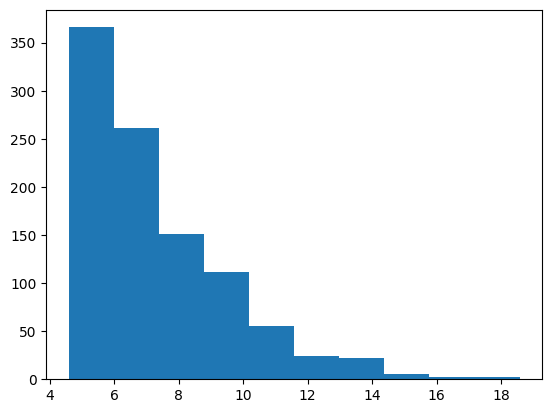

In [96]:
plt.hist(model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=1000).numpy().reshape(-1))

<Axes: >

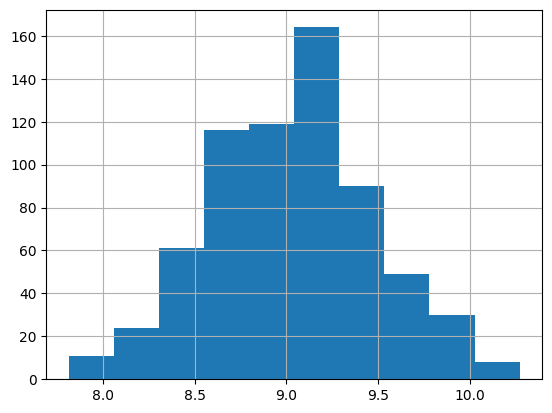

In [80]:
df_tr['mu1'].hist()

In [67]:
import json, os

output_dir = "result/binary"
os.makedirs(output_dir, exist_ok=True)

# Convert each list of (possibly numpy) numbers into plain Python floats
tracker_serializable = {
    model: [float(x) for x in lst]
    for model, lst in tracker.items()
}

with open(os.path.join(output_dir, "ihdp.json"), "w") as f:
    json.dump(tracker_serializable, f, indent=4)

In [268]:
import json
import numpy as np
import pandas as pd

# 1) Load your tracker
with open("result/binary/synthetic_1k_v1.json") as f:
    tracker = json.load(f)

# 2) Define strengths and methods in the order you want
strengths = sorted(tracker.keys(), key=lambda x: float(x))
methods   = ["fr","dr","causalegm","dragonnet"]

# 3) Build a MultiIndex DataFrame
rows = []
index = []
for s in strengths:
    ests = tracker[s]
    # precompute each method’s metrics
    stats = {}
    for m in methods:
        arr = np.array(ests[m])
        stats[m] = {
            "rmse": np.sqrt(((arr - 2.0)**2).mean()),
            "bias": arr.mean() - 2.0,
            "mae":  np.abs(arr - 2.0).mean()
        }
    # for each metric, make one row
    for metric in ["rmse","bias","mae"]:
        index.append((s, metric))
        rows.append([stats[m][metric] for m in methods])

df = pd.DataFrame(rows,
                  index=pd.MultiIndex.from_tuples(index,
                                                  names=["strength","metric"]),
                  columns=methods)

# 4) Formatting function
def fmt(x):
    if 1e-2 <= abs(x) < 1e0:
        return f"{x:.2f}"
    else:
        return f"{x:.3e}"

df_fmt = df.applymap(fmt)

# 5) Print LaTeX
print(df_fmt.to_latex(multicolumn=True, multirow=True, escape=False))


\begin{tabular}{llllll}
\toprule
 &  & fr & dr & causalegm & dragonnet \\
strength & metric &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{0.0} & rmse & 0.11 & 0.19 & 0.27 & 0.13 \\
 & bias & -0.01 & 0.05 & -0.27 & 0.02 \\
 & mae & 0.08 & 0.15 & 0.27 & 0.11 \\
\cline{1-6}
\multirow[t]{3}{*}{0.5} & rmse & 0.15 & 0.35 & 0.34 & 0.12 \\
 & bias & -0.08 & 0.05 & -0.33 & 0.02 \\
 & mae & 0.10 & 0.21 & 0.33 & 0.10 \\
\cline{1-6}
\multirow[t]{3}{*}{1.0} & rmse & 0.12 & 0.30 & 0.42 & 0.13 \\
 & bias & -0.04 & 0.05 & -0.42 & 0.04 \\
 & mae & 0.08 & 0.20 & 0.42 & 0.10 \\
\cline{1-6}
\multirow[t]{3}{*}{1.5} & rmse & 0.12 & 0.36 & 0.49 & 0.05 \\
 & bias & -0.03 & 0.09 & -0.49 & 2.847e-03 \\
 & mae & 0.10 & 0.20 & 0.49 & 0.04 \\
\cline{1-6}
\multirow[t]{3}{*}{2.0} & rmse & 0.14 & 0.26 & 0.57 & 0.09 \\
 & bias & -0.06 & -0.02 & -0.57 & -0.02 \\
 & mae & 0.10 & 0.18 & 0.57 & 0.07 \\
\cline{1-6}
\bottomrule
\end{tabular}



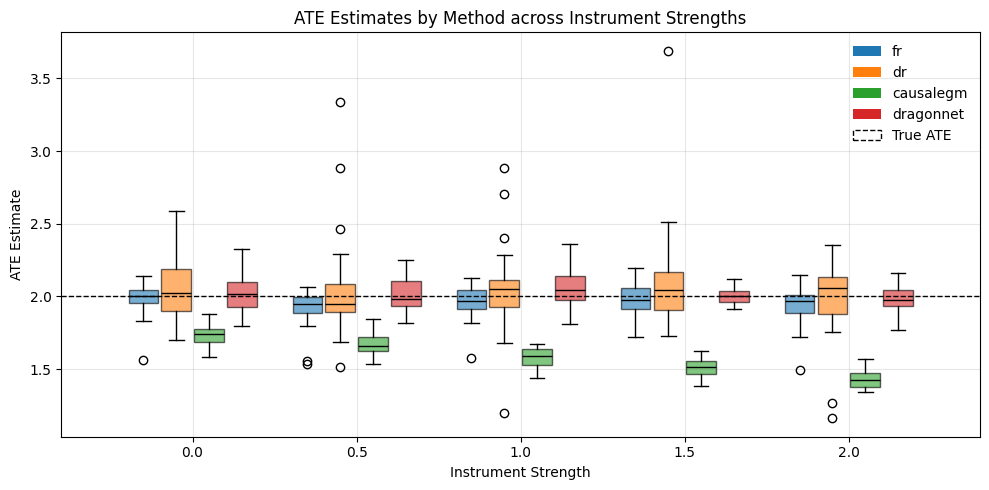

In [267]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load
with open("result/binary/synthetic_1k_v1.json") as f:
    tracker = json.load(f)

strengths = sorted(tracker.keys(), key=lambda x: float(x))
methods   = ["fr","dr","causalegm","dragonnet"]
colors    = {
    "fr":        "#1f77b4",  # blue
    "dr":        "#ff7f0e",  # orange
    "causalegm": "#2ca02c",  # green
    "dragonnet": "#d62728",  # red
}

plt.figure(figsize=(10, 5))
n = len(strengths)
m = len(methods)
width = 0.8 / m

for i, s in enumerate(strengths):
    if i == 1:
        pass 
    for j, meth in enumerate(methods):
        pos = i - 0.4 + j*width + width/2
        data = tracker[s][meth]
        plt.boxplot(data,
                    positions=[pos],
                    widths=width*0.9,
                    patch_artist=True,
                    boxprops=dict(facecolor=colors[meth], alpha=0.6),
                    medianprops=dict(color="black"))

# True ATE line
plt.axhline(2.0, color='black', linestyle='--', linewidth=1)

# Ticks & labels
plt.xticks(ticks=list(range(n)), labels=strengths)
plt.xlabel("Instrument Strength")
plt.ylabel("ATE Estimate")

# Single legend
handles = [Patch(facecolor=colors[m], label=m) for m in methods]
handles.append(Patch(facecolor='none', edgecolor='black', linestyle='--', label='True ATE'))
plt.legend(handles=handles, loc="upper right", frameon=False, ncol=1)

plt.title("ATE Estimates by Method across Instrument Strengths")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


            RMSE   Bias    MAE
method                        
fr         2.161 -2.034  2.034
dr         0.545 -0.002  0.426
causalegm  1.807 -1.671  1.671
tarnet     4.000 -4.000  4.000
cfrnet     4.005 -4.005  4.005
cevae      3.997 -3.997  3.997
dragonnet  0.429  0.095  0.228

LaTeX:
\begin{tabular}{lrrr}
 & RMSE & Bias & MAE \\
method &  &  &  \\
fr & 2.161 & -2.034 & 2.034 \\
dr & 0.545 & -0.002 & 0.426 \\
causalegm & 1.807 & -1.671 & 1.671 \\
tarnet & 4.000 & -4.000 & 4.000 \\
cfrnet & 4.005 & -4.005 & 4.005 \\
cevae & 3.997 & -3.997 & 3.997 \\
dragonnet & 0.429 & 0.095 & 0.228 \\
\end{tabular}



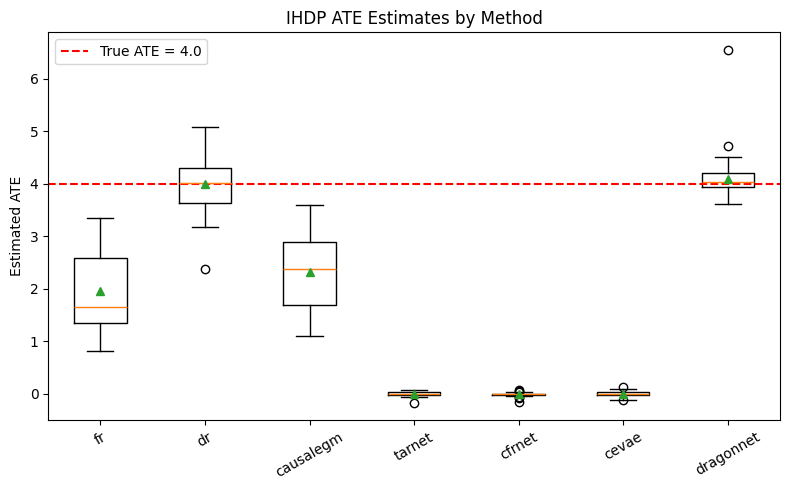

In [68]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1) load your tracker
with open("result/binary/ihdp.json") as f:
    tracker = json.load(f)

true_ate = 4.0
methods = list(tracker.keys())

# 2) compute metrics
rows = []
for m in methods:
    est = np.array(tracker[m])
    rmse = np.sqrt(mean_squared_error(np.full_like(est, true_ate), est))
    bias = est.mean() - true_ate
    mae  = mean_absolute_error(np.full_like(est, true_ate), est)
    rows.append((m, rmse, bias, mae))

df = pd.DataFrame(rows, columns=["method","RMSE","Bias","MAE"]).set_index("method")

# 3) print and latex
print(df.round(3))
print("\nLaTeX:")
print(df.style.format("{:.3f}").to_latex())

# 4) boxplot
plt.figure(figsize=(8,5))
plt.boxplot([tracker[m] for m in methods], labels=methods, showmeans=True)
plt.axhline(true_ate, color="red", linestyle="--", label=f"True ATE = {true_ate}")
plt.ylabel("Estimated ATE")
plt.xticks(rotation=30)
plt.title("IHDP ATE Estimates by Method")
plt.legend()
plt.tight_layout()
plt.show()


In [60]:
tracker

{'fr': [1.8805840015411377,
  1.2293577194213867,
  0.6568965911865234,
  2.7308053970336914,
  6.7533650398254395,
  2.585493803024292,
  3.0861685276031494,
  5.560434818267822,
  3.4496939182281494,
  1.6817498207092285,
  1.768491506576538,
  2.357041358947754,
  3.2762045860290527,
  3.6121296882629395,
  1.6551244258880615,
  2.425121545791626,
  1.7421836853027344,
  4.663026809692383,
  1.9706707000732422,
  3.5590524673461914,
  3.593852996826172,
  0.70867919921875,
  1.2971398830413818,
  3.0945327281951904,
  3.8475189208984375,
  2.3555026054382324,
  2.7034294605255127,
  3.650202512741089,
  3.011929512023926,
  3.8352622985839844,
  2.0407004356384277,
  3.8579959869384766,
  2.9149911403656006,
  3.6666154861450195,
  2.5288898944854736,
  4.005790710449219,
  3.3521881103515625,
  3.1037986278533936,
  4.976897239685059,
  3.2838261127471924,
  2.3750123977661133,
  0.9823637008666992,
  1.7729506492614746,
  4.098163604736328,
  5.935720443725586,
  5.997453689575195